# Read all data
(convert bpm to peaks as needed)

In [181]:
# Do all package imports

import neurokit2 as nk
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io
from pathlib import Path
from scipy.stats import variation
from scipy import stats
from hmmlearn import hmm
import re

In [182]:
filepath_data=Path.cwd()/"data/heartrate" 
filepath_sleep_labels=Path.cwd()/"data/sleep_labels" 

In [183]:
bpm_files = [f for f in sorted(filepath_data.iterdir())  #create a list of relevant files in directory
            if f.suffix == '.txt']
sleep_label_files = [f for f in sorted(filepath_sleep_labels.iterdir())  #create a list of relevant files in directory
            if f.suffix == '.txt']

In [184]:
# Read one file at a time using the above list [bpm_files], clean, convert to RRI
# Proceed with the steps below: HRV compute, save

def read_bpm_file(bpm_files, i,sampling_rate):
    # Import raw HR file in bpm
    bpm_raw=pd.read_csv(bpm_files[i])
    
    # convert bpm to rri followed by rri to peaks
    rri_raw=60000/bpm_raw.iloc[:,1]
    peaks=nk.intervals_to_peaks(rri_raw)

    # Artifact removal using simple neurokit thresholds
    #clean_peaks=nk.signal_fixpeaks(peaks=peaks, interval_min=0.4,interval_max=1.5, method="neurokit") #allow 40-150 bpm

    # Convert now to clean RRI
    #rri = peaks_to_rri(clean_peaks, sampling_rate, interpolate=False)
        
    return peaks

# Sleep state label manipulations 
Compute N3 REM duration as example; 

The script can be changed easily to study systematically sleep state architecture:

wake = 0, N1 = 1, N2 = 2, N3 = 3, REM = 5

In [476]:
#get sleep stats
def duration_sleep(sleep_label_data, SubjectID):
    
    #get duration of sleep label file in hours from last value in "Time, s" column 
    sleep_duration=sleep_label_data.iloc[-1][0]/3600
    
    #select only N3 deep sleep (3rd stage, deepest sleep)
    N3_nrem=sleep_label_data.loc[sleep_label_data['Sleep label'] == 3]
    #Get duration of N3 nrem in minutes by determining the number of rows with this condition;
    #each label is assigned every 30 seconds 
    duration_N3_deep_sleep=len(sleep_label_data[sleep_label_data['Sleep label'] == 3.0])*30/60
    
    # do that for other sleep states
    N2_NREM=sleep_label_data.loc[sleep_label_data['Sleep label'] == 2]
    duration_N2_deep_sleep=len(sleep_label_data[sleep_label_data['Sleep label'] == 2.0])*30/60
    N1_NREM=sleep_label_data.loc[sleep_label_data['Sleep label'] == 1]
    duration_N1_deep_sleep=len(sleep_label_data[sleep_label_data['Sleep label'] == 1.0])*30/60
    REM=sleep_label_data.loc[sleep_label_data['Sleep label'] == 5]
    duration_REM_sleep=len(sleep_label_data[sleep_label_data['Sleep label'] == 5.0])*30/60
    awake=sleep_label_data.loc[sleep_label_data['Sleep label'] == 0]
    duration_awake=len(sleep_label_data[sleep_label_data['Sleep label'] == 0])*30/60
    
    #concatenate SubjectID,sleep state duration metrics; save later as one cohort sleep_df > Excel
    sleep_statistics=[SubjectID,sleep_duration, duration_N3_deep_sleep,duration_N2_deep_sleep,duration_N1_deep_sleep,duration_REM_sleep,duration_awake]
    
    return sleep_statistics #sleep_stats

# HRV UDFs
- HRV ancillary UDFs
- HRV metrics UDFs


- #hrv_time
- #hrv_frequency
- #hrv_rqa
- #hrv_complexity
- complexity_delay
- complexity_dimension
- complexity_tolerance
- #hrv_nonlinear_edited

## HRV ancilllary UDFs

In [186]:
# deal with last column which is string and needs to be skipped

def skip_last_column(lst):
    # unpack the list of lists
    def Extract(lst):
        return [item[0] for item in lst]
    # check for string in the first sublist (all I need to decide to skip it for numpy operations)
    element_to_check=Extract(lst)[0]
    return isinstance(element_to_check, str) #return Boolean for presence of string in the sublist

In [187]:
def compute_basic_stats(ts_data, SubjectID):

    # compute mean and variation
    # assuming "ts_data" is where my HRV metric values list is per subject
    
    HRV_mean=np.mean(ts_data.values.tolist())
    
    HRV_coeff_variation=variation(ts_data.values.tolist())
    # this function works similar to variation() but works purely with numpy
    # cv = lambda x: np.std(x) / np.mean(x)

    # First quartile (Q1) 
    Q1 = np.percentile(ts_data, 25, interpolation = 'midpoint') 
    # Third quartile (Q3) 
    Q3 = np.percentile(ts_data, 75, interpolation = 'midpoint') 
    # Interquaritle range (IQR) 
    IQR = Q3 - Q1 
    midhinge = (Q3 + Q1)/2
    quartile_coefficient_dispersion = (IQR/2)/midhinge
    
    # adding entropy estimate
    
    # HRV_ts_entropy=nk.entropy_sample(ts_data) 
    # yielding error "could not broadcast input array from shape (7,1) into shape (7)" | the following syntax fixes that and is more elegant in that it estimates optimal delay
    # optimal_complexity_parameters = nk.complexity_delay(ts_data.to_numpy, delay_max=6, method='fraser1986', show=False)
    # HRV_ts_entropy=nk.entropy_fuzzy(ts_data.to_numpy, delay=optimal_complexity_parameters)
    # still yielding len error 
    #HRV_ts_entropy=nk.entropy_shannon(ts_data)
        
    basic_stats=[SubjectID, HRV_mean, HRV_coeff_variation[0], quartile_coefficient_dispersion] #, HRV_ts_entropy
    #print(basic_stats)
    return basic_stats

In [188]:
#HMM Model

def do_hmm(ts_data):
    
    #ts_data=numpy.array(data)
    gm = hmm.GaussianHMM(n_components=2)
    gm.fit(ts_data.reshape(-1, 1))
    hmm_states = gm.predict(ts_data.reshape(-1, 1))
    #hmm_states=[states.tolist()]
    print(hmm_states)
    
    return hmm_states # next, add _states_ iteratively for all subjects to states_Uber list to spot patterns

## HRV metrics UDFs

In [189]:
#hrv_nonlinear_edited

from warnings import warn

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats

from neurokit2.complexity import (complexity_lempelziv, entropy_approximate,
                          entropy_fuzzy, entropy_multiscale, entropy_sample,
                          entropy_shannon, fractal_correlation, fractal_dfa,
                          fractal_higuchi, fractal_katz)
from neurokit2.misc import NeuroKitWarning, find_consecutive
from neurokit2.signal import signal_zerocrossings
from neurokit2.hrv.hrv_utils import _hrv_get_rri, _hrv_sanitize_input

def hrv_nonlinear_edited(peaks, sampling_rate=sampling_rate, show=False, **kwargs):
    
     # Sanitize input
    peaks = _hrv_sanitize_input(peaks)
    if isinstance(peaks, tuple):  # Detect actual sampling rate
        peaks, sampling_rate = peaks[0], peaks[1]

    # Compute R-R intervals (also referred to as NN) in milliseconds
    rri, _ = _hrv_get_rri(peaks, sampling_rate=sampling_rate, interpolate=False)

    # Initialize empty container for results
    out = {}

    # Poincaré features (SD1, SD2, etc.)
    out = _hrv_nonlinear_poincare(rri, out)

    # Heart Rate Fragmentation
    out = _hrv_nonlinear_fragmentation(rri, out)

    # Heart Rate Asymmetry
    out = _hrv_nonlinear_poincare_hra(rri, out)

    # DFA
    out = _hrv_dfa(peaks, rri, out, **kwargs)


    # Complexity
    tolerance = 0.2 * np.std(rri, ddof=1) #could be replaced with the individually computer tolerance value
    
    out["ApEn"], _ = entropy_approximate(rri, delay=1, dimension=2, tolerance=tolerance)
    out["SampEn"], _ = entropy_sample(rri, delay=1, dimension=2, tolerance=tolerance)
    out["ShanEn"], _ = entropy_shannon(rri)
    #out["FuzzyEn"], _ = entropy_fuzzy(rri, delay=1, dimension=2, tolerance=tolerance)
    out["MSEn"], _ = entropy_multiscale(rri, delay=1, dimension=2, method="MSEn")
    out["CMSEn"], _ = entropy_multiscale(rri, dimension=2, tolerance=tolerance, method="CMSEn")
    out["RCMSEn"], _ = entropy_multiscale(rri, dimension=2, tolerance=tolerance, method="RCMSEn")

    out["CD"], _ = fractal_correlation(rri, delay=1, dimension=2, **kwargs)
    out["HFD"], _ = fractal_higuchi(rri, k_max=10, **kwargs)
    out["KFD"], _ = fractal_katz(rri)
    out["LZC"], _ = complexity_lempelziv(rri, **kwargs)

    if show:
        _hrv_nonlinear_show(rri, out)

    out = pd.DataFrame.from_dict(out, orient="index").T.add_prefix("HRV_")
    return out



# =============================================================================
# Get SD1 and SD2
# =============================================================================
def _hrv_nonlinear_poincare(rri, out):
    """Compute SD1 and SD2.

    - Do existing measures of Poincare plot geometry reflect nonlinear features of heart rate
    variability? - Brennan (2001)

    """

    # HRV and hrvanalysis
    rri_n = rri[:-1]
    rri_plus = rri[1:]
    x1 = (rri_n - rri_plus) / np.sqrt(2)  # Eq.7
    x2 = (rri_n + rri_plus) / np.sqrt(2)
    sd1 = np.std(x1, ddof=1)
    sd2 = np.std(x2, ddof=1)

    out["SD1"] = sd1
    out["SD2"] = sd2

    # SD1 / SD2
    out["SD1SD2"] = sd1 / sd2

    # Area of ellipse described by SD1 and SD2
    out["S"] = np.pi * out["SD1"] * out["SD2"]

    # CSI / CVI
    T = 4 * out["SD1"]
    L = 4 * out["SD2"]
    out["CSI"] = L / T
    out["CVI"] = np.log10(L * T)
    out["CSI_Modified"] = L ** 2 / T

    return out


def _hrv_nonlinear_poincare_hra(rri, out):
    """Heart Rate Asymmetry Indices.

    - Asymmetry of Poincaré plot (or termed as heart rate asymmetry, HRA) - Yan (2017)
    - Asymmetric properties of long-term and total heart rate variability - Piskorski (2011)

    """

    N = len(rri) - 1
    x = rri[:-1]  # rri_n, x-axis
    y = rri[1:]  # rri_plus, y-axis

    diff = y - x
    decelerate_indices = np.where(diff > 0)[0]  # set of points above IL where y > x
    accelerate_indices = np.where(diff < 0)[0]  # set of points below IL where y < x
    nochange_indices = np.where(diff == 0)[0]

    # Distances to centroid line l2
    centroid_x = np.mean(x)
    centroid_y = np.mean(y)
    dist_l2_all = abs((x - centroid_x) + (y - centroid_y)) / np.sqrt(2)

    # Distances to LI
    dist_all = abs(y - x) / np.sqrt(2)

    # Calculate the angles
    theta_all = abs(np.arctan(1) - np.arctan(y / x))  # phase angle LI - phase angle of i-th point
    # Calculate the radius
    r = np.sqrt(x ** 2 + y ** 2)
    # Sector areas
    S_all = 1 / 2 * theta_all * r ** 2

    # Guzik's Index (GI)
    den_GI = np.sum(dist_all)
    num_GI = np.sum(dist_all[decelerate_indices])
    out["GI"] = (num_GI / den_GI) * 100

    # Slope Index (SI)
    den_SI = np.sum(theta_all)
    num_SI = np.sum(theta_all[decelerate_indices])
    out["SI"] = (num_SI / den_SI) * 100

    # Area Index (AI)
    den_AI = np.sum(S_all)
    num_AI = np.sum(S_all[decelerate_indices])
    out["AI"] = (num_AI / den_AI) * 100

    # Porta's Index (PI)
    m = N - len(nochange_indices)  # all points except those on LI
    b = len(accelerate_indices)  # number of points below LI
    out["PI"] = (b / m) * 100

    # Short-term asymmetry (SD1)
    sd1d = np.sqrt(np.sum(dist_all[decelerate_indices] ** 2) / (N - 1))
    sd1a = np.sqrt(np.sum(dist_all[accelerate_indices] ** 2) / (N - 1))

    sd1I = np.sqrt(sd1d ** 2 + sd1a ** 2)
    out["C1d"] = (sd1d / sd1I) ** 2
    out["C1a"] = (sd1a / sd1I) ** 2
    out["SD1d"] = sd1d  # SD1 deceleration
    out["SD1a"] = sd1a  # SD1 acceleration
    # out["SD1I"] = sd1I  # SD1 based on LI, whereas SD1 is based on centroid line l1

    # Long-term asymmetry (SD2)
    longterm_dec = np.sum(dist_l2_all[decelerate_indices] ** 2) / (N - 1)
    longterm_acc = np.sum(dist_l2_all[accelerate_indices] ** 2) / (N - 1)
    longterm_nodiff = np.sum(dist_l2_all[nochange_indices] ** 2) / (N - 1)

    sd2d = np.sqrt(longterm_dec + 0.5 * longterm_nodiff)
    sd2a = np.sqrt(longterm_acc + 0.5 * longterm_nodiff)

    sd2I = np.sqrt(sd2d ** 2 + sd2a ** 2)
    out["C2d"] = (sd2d / sd2I) ** 2
    out["C2a"] = (sd2a / sd2I) ** 2
    out["SD2d"] = sd2d  # SD2 deceleration
    out["SD2a"] = sd2a  # SD2 acceleration
    # out["SD2I"] = sd2I  # identical with SD2

    # Total asymmerty (SDNN)
    sdnnd = np.sqrt(0.5 * (sd1d ** 2 + sd2d ** 2))  # SDNN deceleration
    sdnna = np.sqrt(0.5 * (sd1a ** 2 + sd2a ** 2))  # SDNN acceleration
    sdnn = np.sqrt(sdnnd ** 2 + sdnna ** 2)  # should be similar to sdnn in hrv_time
    out["Cd"] = (sdnnd / sdnn) ** 2
    out["Ca"] = (sdnna / sdnn) ** 2
    out["SDNNd"] = sdnnd
    out["SDNNa"] = sdnna

    return out


def _hrv_nonlinear_fragmentation(rri, out):
    """Heart Rate Fragmentation Indices - Costa (2017)

    The more fragmented a time series is, the higher the PIP, IALS, PSS, and PAS indices will be.
    """

    diff_rri = np.diff(rri)
    zerocrossings = signal_zerocrossings(diff_rri)

    # Percentage of inflection points (PIP)
    out["PIP"] = len(zerocrossings) / len(rri)

    # Inverse of the average length of the acceleration/deceleration segments (IALS)
    accelerations = np.where(diff_rri > 0)[0]
    decelerations = np.where(diff_rri < 0)[0]
    consecutive = find_consecutive(accelerations) + find_consecutive(decelerations)
    lengths = [len(i) for i in consecutive]
    out["IALS"] = 1 / np.average(lengths)

    # Percentage of short segments (PSS) - The complement of the percentage of NN intervals in
    # acceleration and deceleration segments with three or more NN intervals
    out["PSS"] = np.sum(np.asarray(lengths) < 3) / len(lengths)

    # Percentage of NN intervals in alternation segments (PAS). An alternation segment is a sequence
    # of at least four NN intervals, for which heart rate acceleration changes sign every beat. We note
    # that PAS quantifies the amount of a particular sub-type of fragmentation (alternation). A time
    # series may be highly fragmented and have a small amount of alternation. However, all time series
    # with large amount of alternation are highly fragmented.
    alternations = find_consecutive(zerocrossings)
    lengths = [len(i) for i in alternations]
    out["PAS"] = np.sum(np.asarray(lengths) >= 4) / len(lengths)

    return out


# =============================================================================
# DFA
# =============================================================================
def _hrv_dfa(peaks, rri, out, n_windows="default", **kwargs):

    # if "dfa_windows" in kwargs:
    #    dfa_windows = kwargs["dfa_windows"]
    # else:
    # dfa_windows = [(4, 11), (12, None)]
    # consider using dict.get() mthd directly
    dfa_windows = kwargs.get("dfa_windows", [(4, 11), (12, None)])

    # Determine max beats
    if dfa_windows[1][1] is None:
        max_beats = len(peaks) / 10
    else:
        max_beats = dfa_windows[1][1]

    # No. of windows to compute for short and long term
    if n_windows == "default":
        n_windows_short = int(dfa_windows[0][1] - dfa_windows[0][0] + 1)
        n_windows_long = int(max_beats - dfa_windows[1][0] + 1)
    elif isinstance(n_windows, list):
        n_windows_short = n_windows[0]
        n_windows_long = n_windows[1]

    # Compute DFA alpha1
    short_window = np.linspace(dfa_windows[0][0], dfa_windows[0][1], n_windows_short).astype(int)
    # For monofractal
    out["DFA_alpha1"], _ = fractal_dfa(rri, multifractal=False, scale=short_window, **kwargs)
    # For multifractal
    mdfa_alpha1, _ = fractal_dfa(
        rri, multifractal=True, q=np.arange(-5, 6), scale=short_window, **kwargs
    )
    for k in mdfa_alpha1.columns:
        out["MFDFA_alpha1_" + k] = mdfa_alpha1[k].values[0]

    # Compute DFA alpha2
    # sanatize max_beats
    if max_beats < dfa_windows[1][0] + 1:
        warn(
            "DFA_alpha2 related indices will not be calculated. "
            "The maximum duration of the windows provided for the long-term correlation is smaller "
            "than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` "
            "for more information.",
            category=NeuroKitWarning,
        )
        return out
    else:
        long_window = np.linspace(dfa_windows[1][0], int(max_beats), n_windows_long).astype(int)
        # For monofractal
        out["DFA_alpha2"], _ = fractal_dfa(rri, multifractal=False, scale=long_window, **kwargs)
        # For multifractal
        mdfa_alpha2, _ = fractal_dfa(
            rri, multifractal=True, q=np.arange(-5, 6), scale=long_window, **kwargs
        )
        for k in mdfa_alpha2.columns:
            out["MFDFA_alpha2_" + k] = mdfa_alpha2[k].values[0]

    return out


# =============================================================================
# Plot
# =============================================================================
def _hrv_nonlinear_show(rri, out, ax=None, ax_marg_x=None, ax_marg_y=None):

    mean_heart_period = np.mean(rri)
    sd1 = out["SD1"]
    sd2 = out["SD2"]
    if isinstance(sd1, pd.Series):
        sd1 = float(sd1)
    if isinstance(sd2, pd.Series):
        sd2 = float(sd2)

    # Poincare values
    ax1 = rri[:-1]
    ax2 = rri[1:]

    # Set grid boundaries
    ax1_lim = (max(ax1) - min(ax1)) / 10
    ax2_lim = (max(ax2) - min(ax2)) / 10
    ax1_min = min(ax1) - ax1_lim
    ax1_max = max(ax1) + ax1_lim
    ax2_min = min(ax2) - ax2_lim
    ax2_max = max(ax2) + ax2_lim

    # Prepare figure
    if ax is None and ax_marg_x is None and ax_marg_y is None:
        gs = matplotlib.gridspec.GridSpec(4, 4)
        fig = plt.figure(figsize=(8, 8))
        ax_marg_x = plt.subplot(gs[0, 0:3])
        ax_marg_y = plt.subplot(gs[1:4, 3])
        ax = plt.subplot(gs[1:4, 0:3])
        gs.update(wspace=0.025, hspace=0.05)  # Reduce spaces
        plt.suptitle("Poincaré Plot")
    else:
        fig = None

    # Create meshgrid
    xx, yy = np.mgrid[ax1_min:ax1_max:100j, ax2_min:ax2_max:100j]

    # Fit Gaussian Kernel
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([ax1, ax2])
    kernel = scipy.stats.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    cmap = matplotlib.cm.get_cmap("Blues", 10)
    ax.contourf(xx, yy, f, cmap=cmap)
    ax.imshow(np.rot90(f), extent=[ax1_min, ax1_max, ax2_min, ax2_max], aspect="auto")

    # Marginal densities
    ax_marg_x.hist(
        ax1, bins=int(len(ax1) / 10), density=True, alpha=1, color="#ccdff0", edgecolor="none"
    )
    ax_marg_y.hist(
        ax2,
        bins=int(len(ax2) / 10),
        density=True,
        alpha=1,
        color="#ccdff0",
        edgecolor="none",
        orientation="horizontal",
        zorder=1,
    )
    kde1 = scipy.stats.gaussian_kde(ax1)
    x1_plot = np.linspace(ax1_min, ax1_max, len(ax1))
    x1_dens = kde1.evaluate(x1_plot)

    ax_marg_x.fill(x1_plot, x1_dens, facecolor="none", edgecolor="#1b6aaf", alpha=0.8, linewidth=2)
    kde2 = scipy.stats.gaussian_kde(ax2)
    x2_plot = np.linspace(ax2_min, ax2_max, len(ax2))
    x2_dens = kde2.evaluate(x2_plot)
    ax_marg_y.fill_betweenx(
        x2_plot, x2_dens, facecolor="none", edgecolor="#1b6aaf", linewidth=2, alpha=0.8, zorder=2
    )

    # Turn off marginal axes labels
    ax_marg_x.axis("off")
    ax_marg_y.axis("off")

    # Plot ellipse
    angle = 45
    width = 2 * sd2 + 1
    height = 2 * sd1 + 1
    xy = (mean_heart_period, mean_heart_period)
    ellipse = matplotlib.patches.Ellipse(
        xy=xy, width=width, height=height, angle=angle, linewidth=2, fill=False
    )
    ellipse.set_alpha(0.5)
    ellipse.set_facecolor("#2196F3")
    ax.add_patch(ellipse)

    # Plot points only outside ellipse
    cos_angle = np.cos(np.radians(180.0 - angle))
    sin_angle = np.sin(np.radians(180.0 - angle))
    xc = ax1 - xy[0]
    yc = ax2 - xy[1]
    xct = xc * cos_angle - yc * sin_angle
    yct = xc * sin_angle + yc * cos_angle
    rad_cc = (xct ** 2 / (width / 2.0) ** 2) + (yct ** 2 / (height / 2.0) ** 2)

    points = np.where(rad_cc > 1)[0]
    ax.plot(ax1[points], ax2[points], "o", color="k", alpha=0.5, markersize=4)

    # SD1 and SD2 arrow
    sd1_arrow = ax.arrow(
        mean_heart_period,
        mean_heart_period,
        float(-sd1 * np.sqrt(2) / 2),
        float(sd1 * np.sqrt(2) / 2),
        linewidth=3,
        ec="#E91E63",
        fc="#E91E63",
        label="SD1",
    )
    sd2_arrow = ax.arrow(
        mean_heart_period,
        mean_heart_period,
        float(sd2 * np.sqrt(2) / 2),
        float(sd2 * np.sqrt(2) / 2),
        linewidth=3,
        ec="#FF9800",
        fc="#FF9800",
        label="SD2",
    )

    ax.set_xlabel(r"$RR_{n} (ms)$")
    ax.set_ylabel(r"$RR_{n+1} (ms)$")
    ax.legend(handles=[sd1_arrow, sd2_arrow], fontsize=12, loc="best")

    return fig

# Compute HRV

In [450]:
# UDF compute_HRV
# This UDF computes all [regular and extra non-linear] HRV metrics segment-wise for a HR recording

def compute_HRV(peaks, SubjectID,sampling_rate,divider):
    
    segment=np.array_split(peaks,divider) #divide in segments of X min; the last segment may be shorter; discard during statistical analysis on HRV metrics

    #create my dataframe structure to which to append the list as a row in the following
    hrv_extra_columns=['optimal time delay','optimal complexity dim','optimal complexity tolerance','segment duration, s','SubjectID']
    hrv_extra_complexity_df=pd.DataFrame(columns=hrv_extra_columns)
    #df_length=len(hrv_extra_complexity_df)
    
    #hrv_complexity_parameters_etc_df_total=pd.DataFrame(columns=hrv_extra_columns)

    for i in range(len(segment)):
        #hrv_time
        hrv_time_domain_segment=nk.hrv_time(segment[i],sampling_rate=sampling_rate, show=False)
        #hrv_frequency
        hrv_frequency_domain_segment=nk.hrv_frequency(segment[i],sampling_rate=sampling_rate, show=False)
        #hrv_rqa
        hrv_rqa_domain_segment=nk.hrv_rqa(segment[i],sampling_rate=sampling_rate, show=False)
        
        #optimal complexity_parameters
        #optimal_complexity_delay_value,df_optimal_complexity_delay = nk.complexity_delay(segment[i], delay_max=500, method='rosenstein1994', show=False)
        optimal_complexity_delay_value=1
        #complexity_dimension
        #optimal_complexity_dimension_value,df_optimal_complexity_dimension = nk.complexity_dimension(segment[i], delay=optimal_complexity_delay_value, dimension_max=20, method='afnn', show=False)
        optimal_complexity_dimension_value=2
        #complexity_tolerance
        #optimal_complexity_tolerance_value,df_optimal_complexity_tolerance = nk.complexity_tolerance(segment[i], delay=optimal_complexity_delay_value, dimension=optimal_complexity_dimension_value, method='maxApEn', show=False)
        optimal_complexity_tolerance_value=0.02
        
        #hrv_complexity
        df_hrv_complexity_segment, hrv_segment=nk.complexity(segment[i],delay=optimal_complexity_delay_value,which = ["fast", "medium"])
        
        #hrv_nonlinear_edited
        #calling the internally edited hrv_nonlinear UDF where I removed fuzz_entropy with segment-specific complexity parameters (delay, dimension, tolerance)
        hrv_nonlinear_domain_segment = hrv_nonlinear_edited(segment[i], sampling_rate=sampling_rate, show=False)

        segment_duration=np.sum(segment[i])/1000 #segment duration in seconds
        
        #join all individual output floats including values of segment[i] - i.e., for each segment - and its duration in seconds as numpy.sum(segment[1])/1000 
        hrv_complexity_parameters_etc = [optimal_complexity_delay_value,optimal_complexity_dimension_value,optimal_complexity_tolerance_value,segment_duration,SubjectID]
        hrv_extra_complexity_df.loc[len(hrv_extra_complexity_df)]=hrv_complexity_parameters_etc
        # simply concatenate both df's horizontally; this scales allowing addition of other df's from bivariate computations
        hrv_final_df = pd.concat([hrv_time_domain_segment,hrv_frequency_domain_segment, hrv_rqa_domain_segment, df_hrv_complexity_segment, hrv_nonlinear_domain_segment,hrv_extra_complexity_df],axis=1)
        
    return hrv_final_df #this is per subject with SubjectID output along on the right side

In [468]:
# UDF compute_HRV
# This UDF computes all [regular and extra non-linear] HRV metrics for a _whole_ HR recording

def compute_HRV_whole(peaks, SubjectID,sampling_rate,divider):
    
    segment=np.array_split(peaks,divider) #divide in segments of X min; the last segment may be shorter; discard during statistical analysis on HRV metrics

    #create my dataframe structure to which to append the list as a row in the following
    hrv_extra_columns=['optimal time delay','optimal complexity dim','optimal complexity tolerance','segment duration, s','SubjectID']
    hrv_extra_complexity_df=pd.DataFrame(columns=hrv_extra_columns)
    #df_length=len(hrv_extra_complexity_df)
    
    #hrv_complexity_parameters_etc_df_total=pd.DataFrame(columns=hrv_extra_columns)

    for i in range(len(segment)):
        #hrv_time
        hrv_time_domain_segment=nk.hrv_time(segment[i],sampling_rate=sampling_rate, show=False)
        #hrv_frequency
        hrv_frequency_domain_segment=nk.hrv_frequency(segment[i],sampling_rate=sampling_rate, show=False)
        #hrv_rqa
        hrv_rqa_domain_segment=nk.hrv_rqa(segment[i],sampling_rate=sampling_rate, show=False)
        
        #optimal complexity_parameters [set to default here for speed of compute]
        #optimal_complexity_delay_value,df_optimal_complexity_delay = nk.complexity_delay(segment[i], delay_max=500, method='rosenstein1994', show=False)
        optimal_complexity_delay_value=1
        #complexity_dimension
        #optimal_complexity_dimension_value,df_optimal_complexity_dimension = nk.complexity_dimension(segment[i], delay=optimal_complexity_delay_value, dimension_max=20, method='afnn', show=False)
        optimal_complexity_dimension_value=2
        #complexity_tolerance
        #optimal_complexity_tolerance_value,df_optimal_complexity_tolerance = nk.complexity_tolerance(segment[i], delay=optimal_complexity_delay_value, dimension=optimal_complexity_dimension_value, method='maxApEn', show=False)
        optimal_complexity_tolerance_value=0.02
        
        #hrv_complexity
        df_hrv_complexity_segment, hrv_segment=nk.complexity(segment[i],delay=optimal_complexity_delay_value,which = ["fast", "medium"])
        
        #hrv_nonlinear_edited
        #calling the internally edited hrv_nonlinear UDF where I removed fuzz_entropy with segment-specific complexity parameters (delay, dimension, tolerance)
        hrv_nonlinear_domain_segment = hrv_nonlinear_edited(segment[i], sampling_rate=sampling_rate, show=False)

        #join all individual output floats including values of segment[i] - i.e., for each segment - and its duration in seconds as numpy.sum(segment[1])/1000 
        hrv_complexity_parameters_etc = [optimal_complexity_delay_value,optimal_complexity_dimension_value,optimal_complexity_tolerance_value,SubjectID]
        hrv_extra_complexity_df.loc[len(hrv_extra_complexity_df)]=hrv_complexity_parameters_etc
        # simply concatenate both df's horizontally; this scales allowing addition of other df's from bivariate computations
        hrv_final_df = pd.concat([hrv_time_domain_segment,hrv_frequency_domain_segment, hrv_rqa_domain_segment, df_hrv_complexity_segment, hrv_nonlinear_domain_segment,hrv_extra_complexity_df],axis=1)

    return hrv_final_df #this is per subject with SubjectID output along on the right side

# Compute higher order HRV metrics
This includes statistical and HMM estimates

In [192]:
def compute_higher_HRV(hrv_final_df): 
    
    # assuming "hrv_final_df" is the dataframe where my HRV metric values are listed segment-wise per subject
    
    # compute basic stats
    
    higher_order_HRV_basic_stats=[]
    
    #print(type(hrv_final_df.iloc[:,[0]].to_numpy()))
    #print(hrv_final_df.iloc[:,[i]])
    #print(hrv_final_df.iloc[:,[0]].to_numpy().dtype)
    
    
    for i in range(hrv_final_df.shape[1]): #last column is the SubjectID string, so skipping it below
        #print(type(hrv_final_df.iloc[:,[i]]))
        
        hrv_metric=hrv_final_df.iloc[:,[i]].values
        #print(type(hrv_metric))
        
        #String skip logic to skip over SubjectID column
        if skip_last_column(hrv_final_df.iloc[:,[i]].values) == False:
            HRV_results_temp1=compute_basic_stats(hrv_final_df.iloc[:,[i]].astype(np.float64),SubjectID)
            higher_order_HRV_basic_stats.append(HRV_results_temp1)
    
        else:
            i+=1

    HRV_basic_stats=pd.DataFrame(higher_order_HRV_basic_stats, columns=['SubjectID','HRV_mean', 'HRV_coeff_variation', 'quartile_coefficient_dispersion','HRV metrics entropy'])
    hrv_columns=hrv_final_df.columns[0:63] #make sure I don't select the last column which has SubjectID
    #print(hrv_columns)
    HRV_basic_stats.index=[hrv_columns]
    HRV_basic_stats_final=HRV_basic_stats.T                                 #transpose
    
    # Estimate HMM probabilities output for a given segmented HRV metric
    # Then compute basic_stats on this estimate;
    # Hypothesis: stable tracings will have tight distributions of HMM values and resemble entropy estimates;
    # This will apply statistically significantly for stressed (tighter distributions) versus control subjects

    higher_order_HRV_basic_stats_on_HMM=[]
    
    
    for i in range(hrv_final_df.shape[1]): #last column is the SubjectID string, so removing it
        
        hrv_metric=hrv_final_df.iloc[:,[i]].values
        print("HRV_metric has the type", type(hrv_metric))
        # some HRV metrics have NaNs and the "do_hmm" script crashes on those; 
        # Adding logic to skip if NaN is present
        a=any(pd.isna(hrv_metric)) #checking if _any_ values in HRV metrics list are NaN
        b=skip_last_column(hrv_metric)
        skip_reasons={a:'True', b:'True'}
        #NaN or string skip logic
        if any(skip_reasons):
            i+=1
        else:
            HRV_results_hmm_temp2=do_hmm(hrv_metric)
            print(HRV_results_hmm_temp2)
            print(type(HRV_results_hmm_temp2))
            HRV_results_stats_hmm_temp=compute_basic_stats(HRV_results_hmm_temp2.tolist(),SubjectID) #j being the file number; != SubjectID
            higher_order_HRV_basic_stats_on_HMM.append(HRV_results_stats_hmm_temp)
    
    HRV_basic_stats_on_HMM=pd.DataFrame(higher_order_HRV_basic_stats_on_HMM, columns=['HRV_HMM_mean', 'HRV_HMM_coeff_variation', 'HMM_quartile_coefficient_dispersion','HMM_HRV metrics entropy'])
    HRV_basic_stats_on_HMM.index=[hrv_columns]
    HRV_basic_stats_on_HMM_final=HRV_basic_stats_on_HMM.T                  #transpose
        
    higher_hrv_final_df=pd.concat([HRV_basic_stats_final, HRV_basic_stats_on_HMM_final],axis=1)    
    
    #higher_hrv_final_df=HRV_basic_stats_final #leaving the syntax above for when the data allow HMM analysis    
        
    return higher_hrv_final_df #this includes SubjectID

#one could change the df saved by splitting into four separate DFs: just for mean values, just for CV, etc. That will make later corr easier.

# Vizualization of sleep states architecture, HR, HRV metrics 

In [273]:
#import matplotlib.dates as md

#based on https://neuropsychology.github.io/NeuroKit/functions/complexity.html?highlight=rolling%20complexity

#plot computed complexity overtime overlayed with HR during sleep;save the figure for each SubjectID 

from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

def vizualize_hrv_sleep_states(sleep_label_data,hr_df,rolling_sampen, SubjectID):

    fontprops = fm.FontProperties(size=18)

    plt.rcParams["figure.autolayout"] = True

    fig, ax=plt.subplots(3,1, figsize=(15,8))

    df1=sleep_label_data
    df2=hr_df
    df3=rolling_sampen.to_frame(name="SampEn")
  
    ax[0].plot(df2.iloc[:,1])
    ax[0].set_title("HR")
    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(True)
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)
    ax[0].spines['left'].set_visible(True)

    ax[1].plot(df3.iloc[:,0])
    ax[1].set_title("SampEn")
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(True)
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['bottom'].set_visible(False)
    ax[1].spines['left'].set_visible(True)

    ax[2].plot(df1)
    ax[2].set_title("Sleep state architecture")
    ax[2].get_xaxis().set_visible(True)
    ax[2].set(xlabel='Time, s')
    ax[2].get_yaxis().set_visible(True)
    ax[2].spines['top'].set_visible(False)
    ax[2].spines['right'].set_visible(False)
    ax[2].spines['bottom'].set_visible(True)
    ax[2].spines['left'].set_visible(True)
    
    scalebar = AnchoredSizeBar(ax[2].transData,
                           3600, '60 m', 'lower right', 
                           pad=0.1, borderpad=0.5,sep=5,   #optimize as needed, e.g., bbox_to_anchor=Bbox.from_bounds(0, 0, 1, 1)
                           frameon=False,
                           fontproperties=fontprops)

    
    ax[2].add_artist(scalebar)
    
    plt.savefig(f"analysis/{SubjectID}plot.png",dpi=300)

    plt.show()

    return print(f"Subject {SubjectID}:heart rate, Sample Entropy and Sleep state architecture. File saved as {SubjectID}plot.png")

# Execute the entire analysis
1. Read heart rate and sleep labels files
2. Compute HRV and sleep metrics
3. Save dataframes
4. Perform viz and stats


In [469]:
# Generalized execution of HRV compute for any univariate peaks or RRi input 
# Using raw heart rate data, but could change to neurokit's or other artifact correction engine if desired.

# Initialize data structures
Uber_HRV=[]

i=0

sampling_rate=1000 #be careful to update as needed

#sliding_window_duration=20 #in minutes, adjust as needed; 5 minutes is the lower physiological limit; the smaller the value, the longer it will take in total to compute over the entire recording; the longer the value, the cruder the dynamic HRV estimate

# Compute & save into lists of lists

while i<=len(bpm_files)-1:   

    # read the raw bpm file, artifact correct it, convert to RRIs and return the results 
    peaks=read_bpm_file(bpm_files, i,sampling_rate)  
    
    #determine the number of sliding windows [=divider]to compute HRV on
    #duration_peaks=peaks[len(peaks)-1] #gives me the duration in samples

    #divider=duration_peaks/60/sliding_window_duration  #sliding_window_duration (min)
    
    #get the subject ID from the filename; adjust this as per naming convention in a dataset
    ID=format(bpm_files[i].stem)
    # getting numbers from string
    temp = re.findall(r'\d+', ID)
    SubjectID = list(map(int, temp))[0]

    # compute all HRV metrics
    HRV_final=compute_HRV_whole(peaks,SubjectID, sampling_rate, 1)
    
    # update the UBER df
    Uber_HRV.append(HRV_final)
    
    #executing higher HRV and sleep separately below for ease of troubleshooting; technically, all the three steps can be done in one loop here
    
    i+=1
    
    if i>len(bpm_files):  
        break
        
print('Computation of time segment-wise HRV metrics completed.')

Computation of time segment-wise HRV metrics completed.


In [451]:
#troubleshooting: compute & save all HRV metrics for a single HR recording

Uber_HRV=[]

sampling_rate=1000 #be careful to update as needed

peaks=read_bpm_file(bpm_files, 0,sampling_rate)  
    
#determine the number of sliding windows [=divider]to compute HRV on
duration_peaks=peaks[len(peaks)-1] #gives me the duration in samples

#divider=duration_peaks/60/sliding_window_duration  #sliding_window_duration (min)
    
#get the subject ID from the filename; adjust this as per naming convention in a dataset
ID=format(bpm_files[i].stem)
# getting numbers from string
temp = re.findall(r'\d+', ID)
SubjectID = list(map(int, temp))[0]

# compute all HRV metrics
HRV_final=compute_HRV(peaks,SubjectID, sampling_rate, 1) #use the entire recording, rather than sliding window
    
# update the UBER df
Uber_HRV.append(HRV_final)
        
print('Computation of time segment-wise HRV metrics completed.')

# save HRV and sleep results
Uber_HRV_df=pd.concat(Uber_HRV)
Uber_HRV_df.to_excel("analysis/Sample_HRV_metrics.xlsx")

Computation of time segment-wise HRV metrics completed.


In [470]:
Uber_HRV

[   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
 0  990.477672  111.212974   79.259575   62.428444   74.035235   70.604291   
 
    HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_RCMSEn    HRV_CD  \
 0   65.869722   81.476506   53.32182  53.323425  ...    1.665799  0.816266   
 
     HRV_HFD   HRV_KFD   HRV_LZC  optimal time delay  optimal complexity dim  \
 0  1.574882  3.197034  0.133318                 1.0                     2.0   
 
    optimal complexity tolerance  segment duration, s  SubjectID  
 0                          0.02           16457777.0  1066528.0  
 
 [1 rows x 129 columns],
    HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
 0  851.185042  84.906506   73.026406   39.095115   70.099066   42.470791   
 
    HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_RCMSEn   HRV_CD  \
 0   66.401981   51.134541  32.427847  32.430168  ...      1.7703  0.83808   
 
     HRV_HFD   HRV_KFD   HRV_LZC  optimal tim

In [471]:
# save HRV and sleep results
Uber_HRV_df=pd.concat(Uber_HRV)
Uber_HRV_df.to_excel("analysis/HRV_metrics.xlsx")

In [ ]:
# Compute higher HRV & save into lists
# This is for the case when we compute HRV in sliding windows and have more than ~7 data points per subject
# Doing so increases time to compute and was skipped in this demo run

Uber_higher_HRV=[]


i=0

while i<=len(bpm_files)-1:   

    # compute higher_order HRV metrics
    HRV_higher_final=compute_higher_HRV(HRV_final)
    
    # update the UBER_higher_df
    Uber_higher_HRV.append(HRV_higher_final)   
    
    i+=1
    
    if i>len(bpm_files):  
        break
        
print('Computation of higher HRV metrics completed.')

In [ ]:
Uber_higher_HRV_df=pd.concat(Uber_higher_HRV)
Uber_higher_HRV_df.to_excel("analysis/higher_HRV_metrics.xlsx")

In [477]:
# Compute sleep stats & save into dataframe

Uber_sleep=[]

i=0
    
sleep_statistics_labels=['SubjectID','sleep_duration, h', 'duration N3 NREM, min','duration N2 NREM, min','duration N1 NREM, min','duration REM, min','duration awake, min']

while i<=len(bpm_files)-1:   #assuming equal number of sleep states and HR files
    
    # read sleep state file
    sleep_label_data = pd.read_csv(sleep_label_files[i],sep=" ",header=None, 
                 names=["Time, s", "Sleep label"])
    
    #get the subject ID from the filename; adjust this as per naming convention in a dataset
    ID=format(bpm_files[i].stem)
    # getting numbers from string
    temp = re.findall(r'\d+', ID)
    SubjectID = list(map(int, temp))[0]

    
    # compute sleep label stats
    sleep_stats=duration_sleep(sleep_label_data, SubjectID)
    
    # update the UBER_sleep_df
    Uber_sleep.append(sleep_stats)  
    
    i+=1
    
    if i>len(bpm_files):  
        break
        
print('Computation of sleep metrics completed.')

#save it all into a dataframe
Uber_sleep_df=pd.DataFrame(Uber_sleep, columns=sleep_statistics_labels)

Computation of sleep metrics completed.


In [478]:
#Uber_sleep_df=pd.concat(Uber_sleep)
Uber_sleep_df.to_excel("analysis/sleep.xlsx")

# Combine and save everything: HRV plus higher order spreadsheets

In [ ]:
# save HRV and sleep results
Uber_HRV_df=pd.concat(Uber_HRV)
Uber_HRV_df.to_excel("analysis/HRV_metrics.xlsx")

Uber_higher_HRV_df=pd.concat(Uber_higher_HRV)
Uber_higher_HRV_df.to_excel("analysis/higher_HRV_metrics.xlsx")

#Uber_sleep_df=pd.concat(Uber_sleep)
Uber_sleep_df.to_excel("analysis/sleep.xlsx")

# Now do a) viz to demo the sleep state dynamics and b) correlation matrix btw HRV metrics and N3 NREM duration 

### VIZ: comp example HRV complexity metric and plot with heart rate & sleep state architecture
### also save SampEn and sleep state stats to correlate

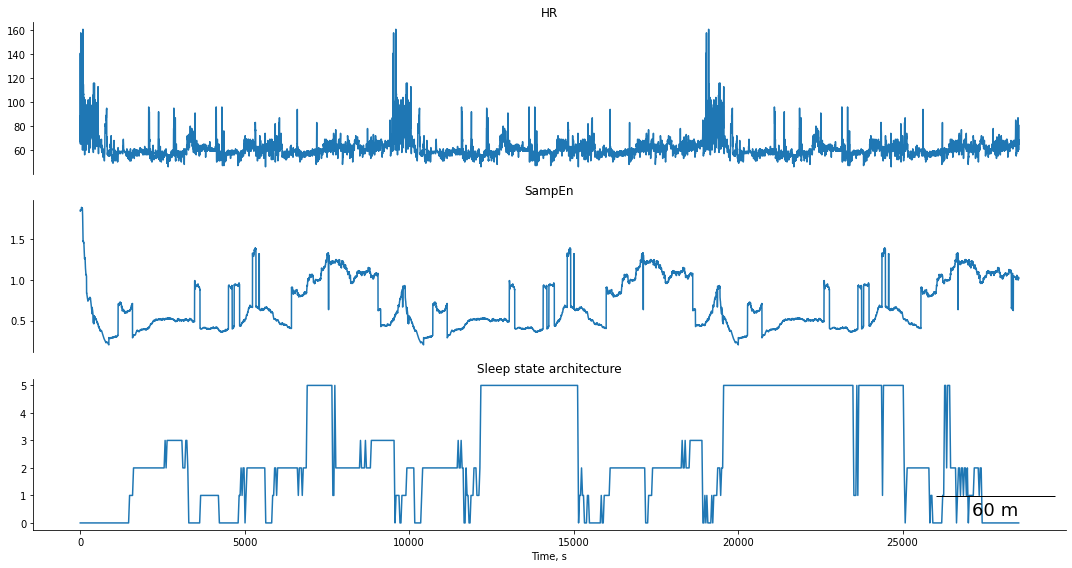

Subject 1066528:heart rate, Sample Entropy and Sleep state architecture. File saved as 1066528plot.png


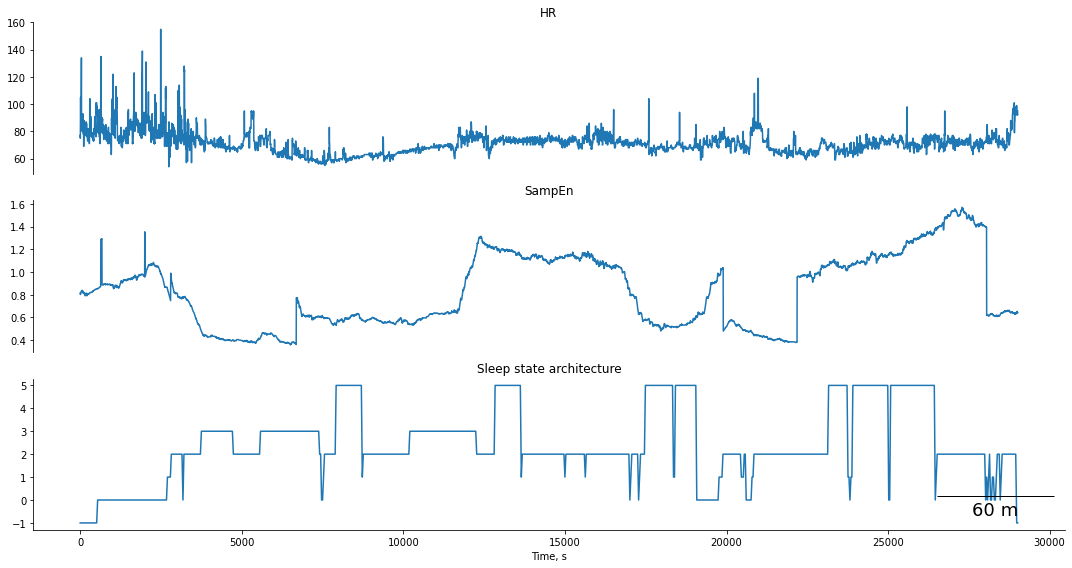

Subject 1360686:heart rate, Sample Entropy and Sleep state architecture. File saved as 1360686plot.png


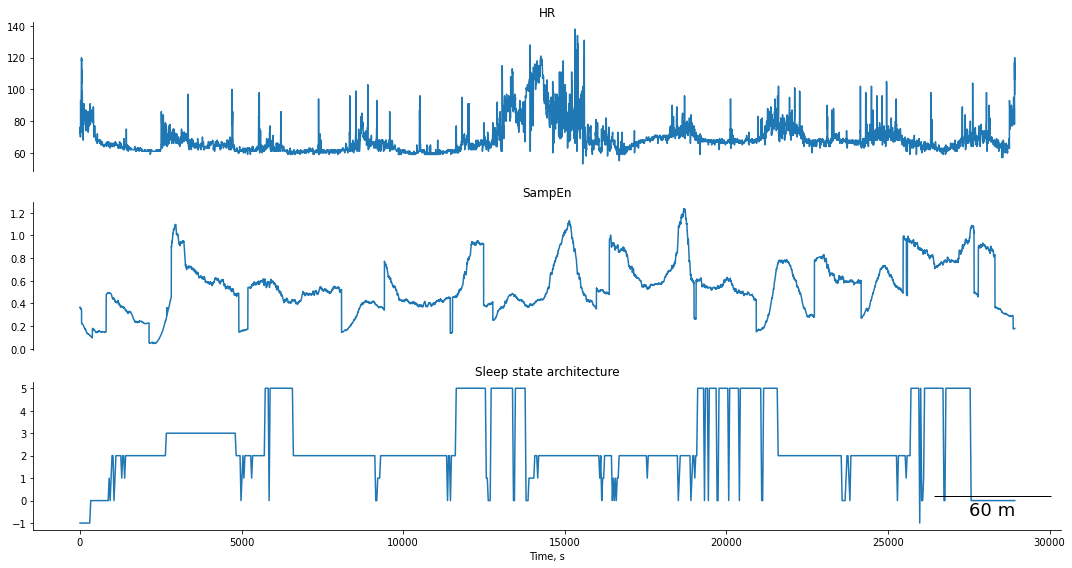

Subject 1449548:heart rate, Sample Entropy and Sleep state architecture. File saved as 1449548plot.png


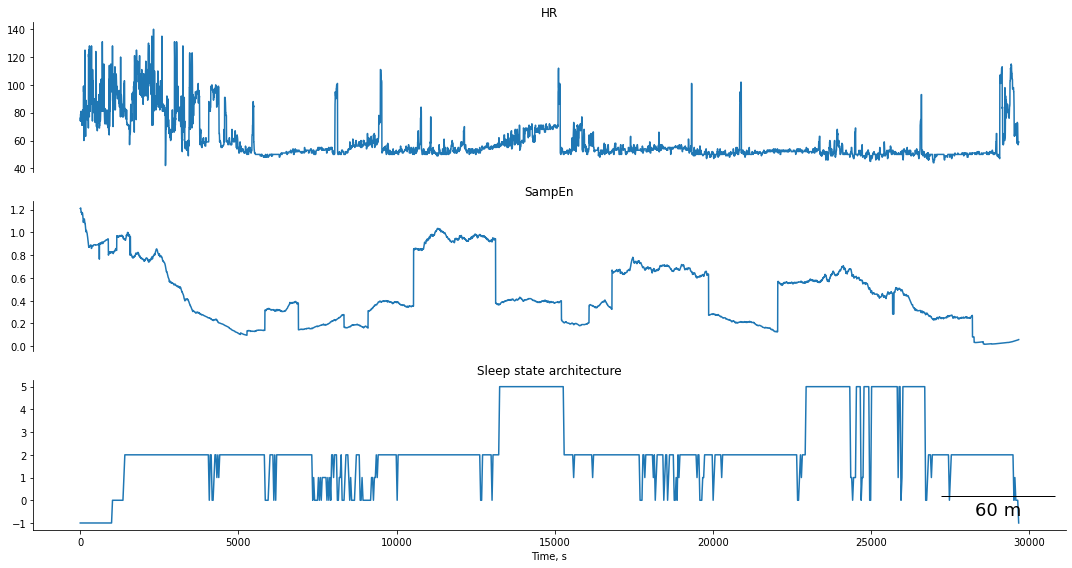

Subject 1455390:heart rate, Sample Entropy and Sleep state architecture. File saved as 1455390plot.png


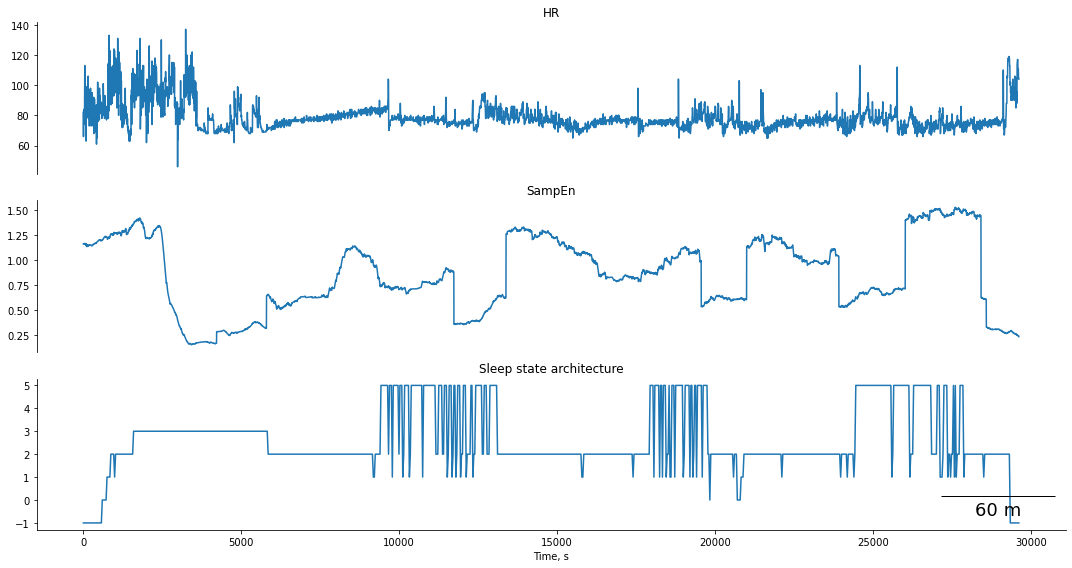

Subject 1818471:heart rate, Sample Entropy and Sleep state architecture. File saved as 1818471plot.png


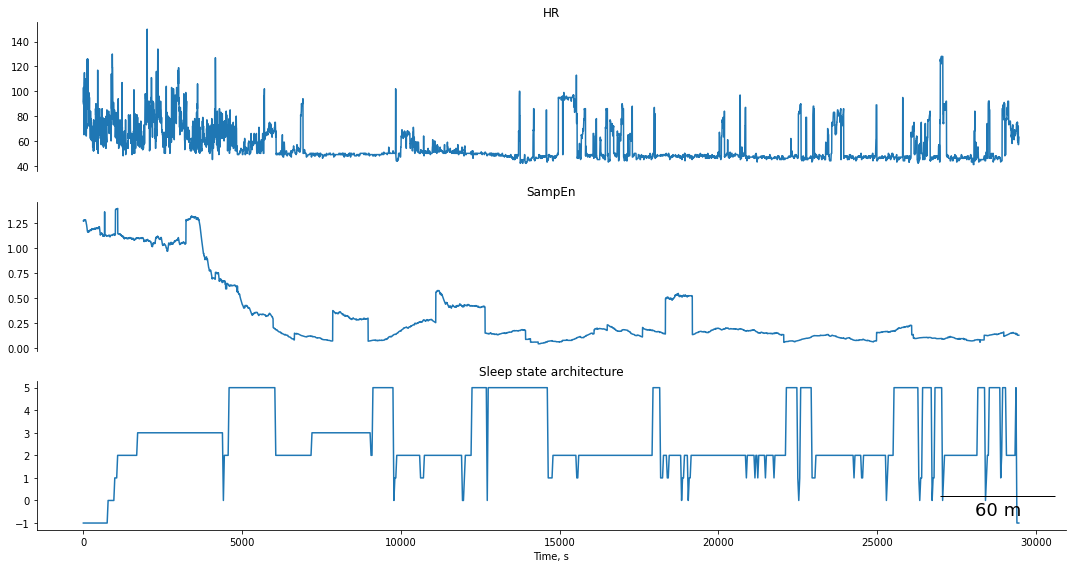

Subject 2598705:heart rate, Sample Entropy and Sleep state architecture. File saved as 2598705plot.png


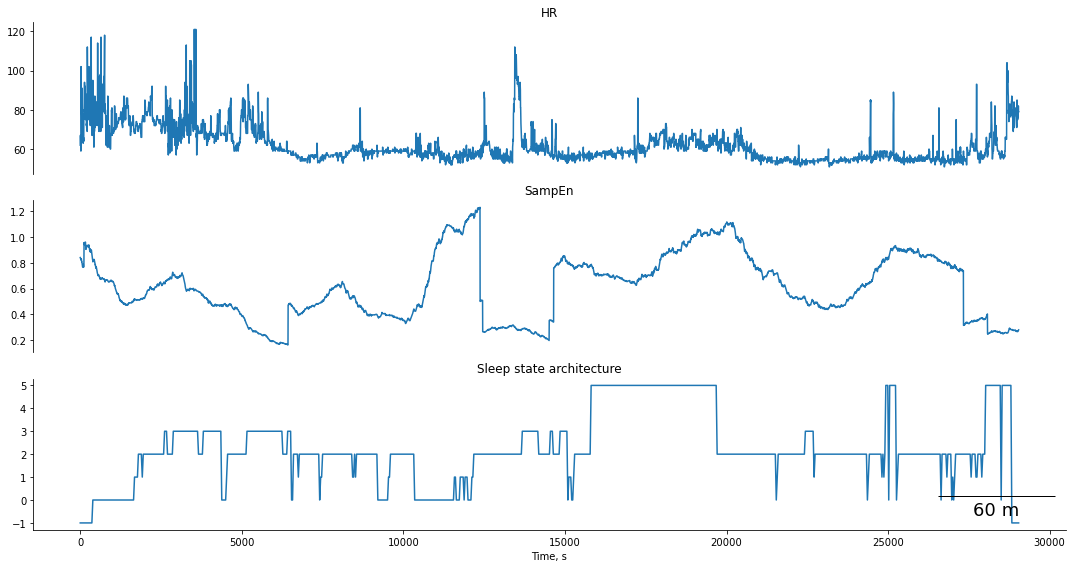

Subject 2638030:heart rate, Sample Entropy and Sleep state architecture. File saved as 2638030plot.png


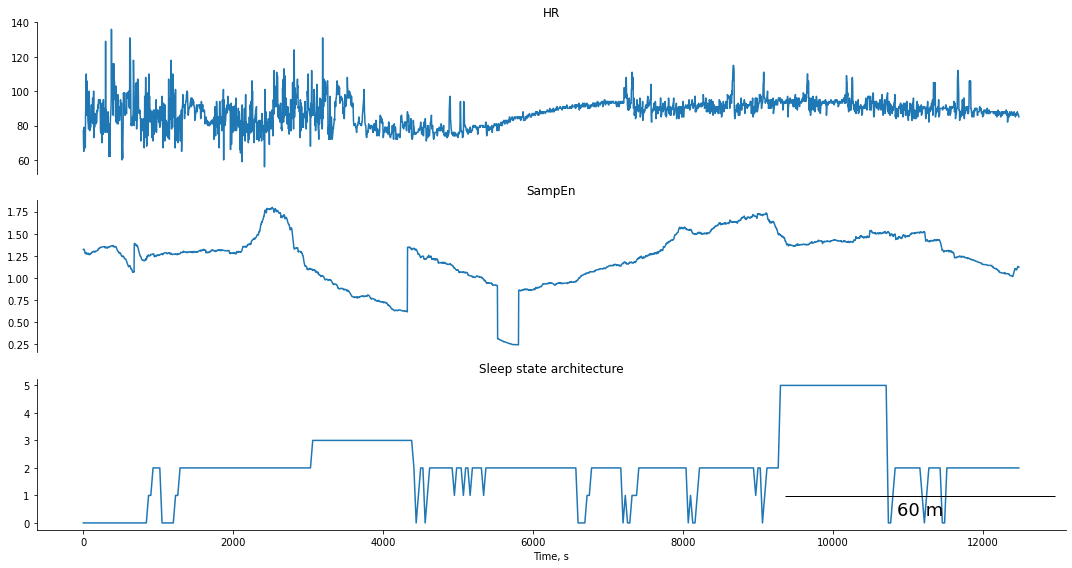

Subject 3509524:heart rate, Sample Entropy and Sleep state architecture. File saved as 3509524plot.png


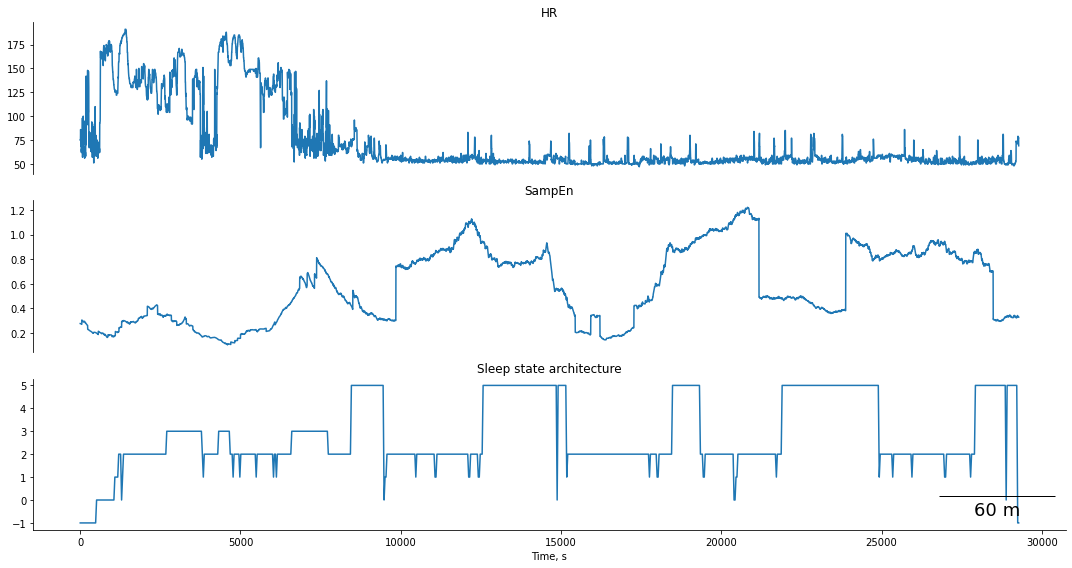

Subject 3997827:heart rate, Sample Entropy and Sleep state architecture. File saved as 3997827plot.png


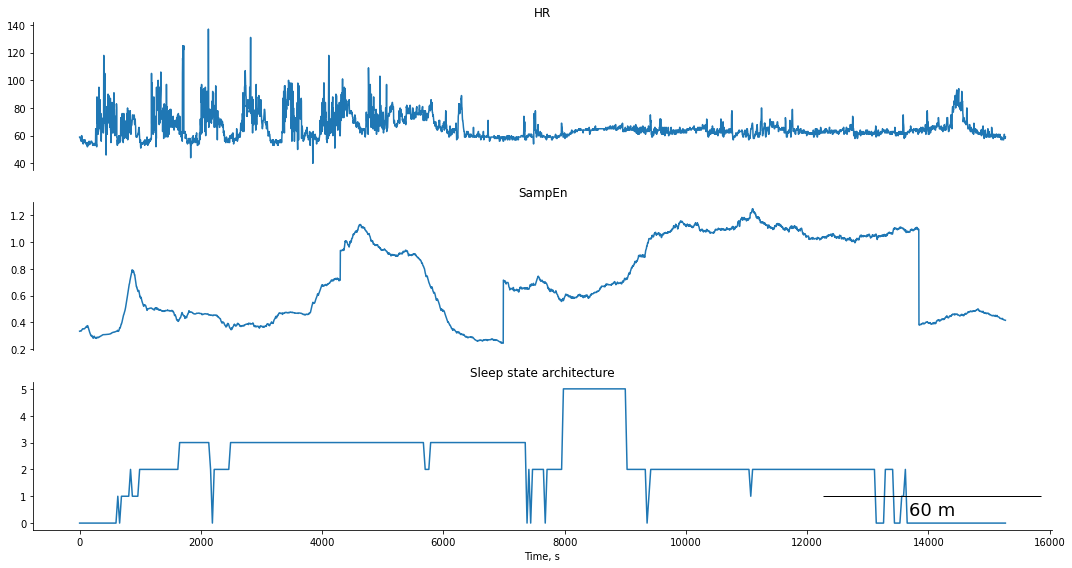

Subject 4018081:heart rate, Sample Entropy and Sleep state architecture. File saved as 4018081plot.png


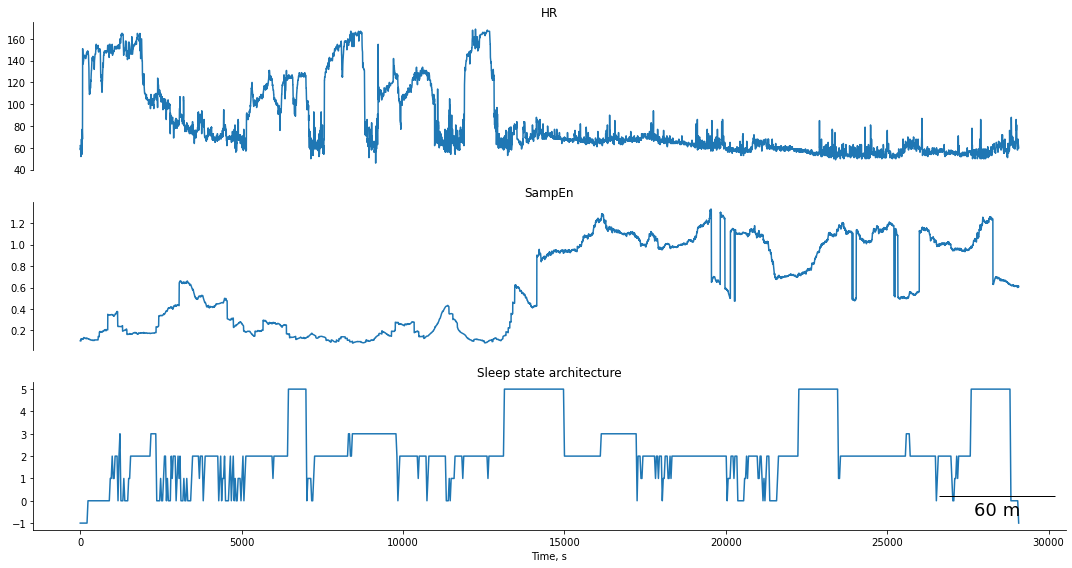

Subject 4314139:heart rate, Sample Entropy and Sleep state architecture. File saved as 4314139plot.png


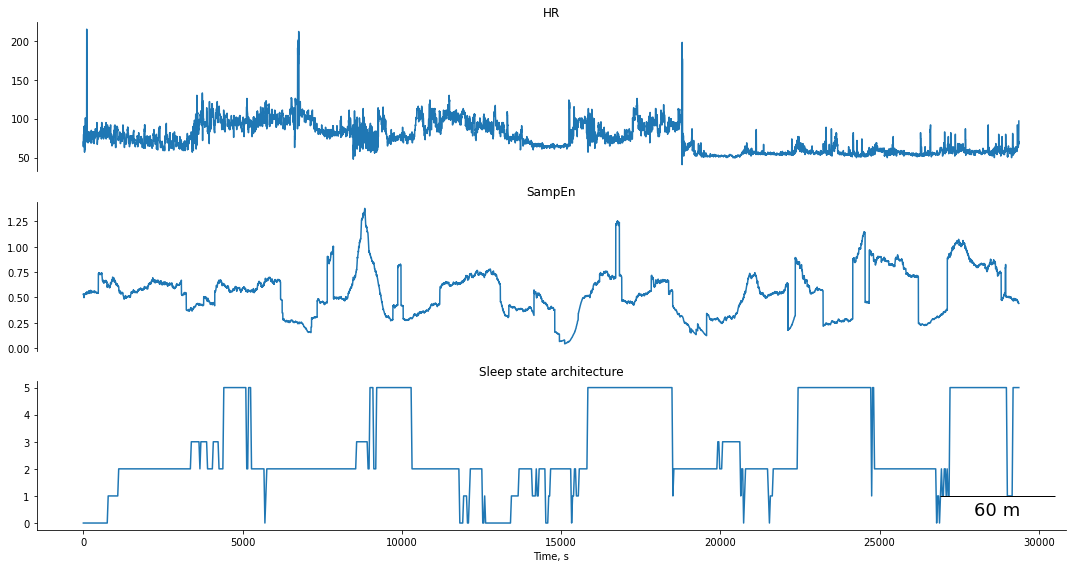

Subject 4426783:heart rate, Sample Entropy and Sleep state architecture. File saved as 4426783plot.png


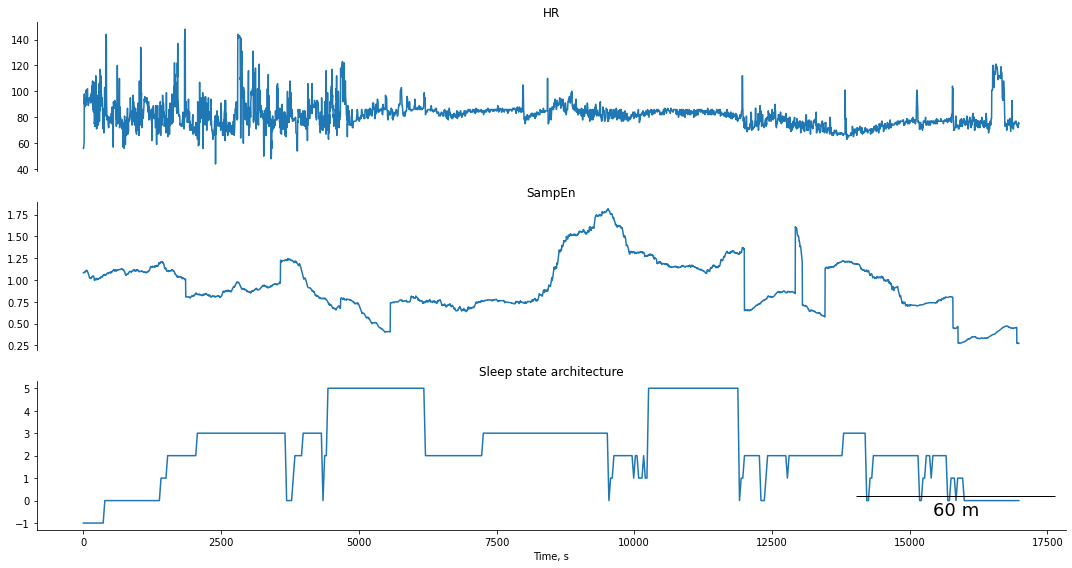

Subject 46343:heart rate, Sample Entropy and Sleep state architecture. File saved as 46343plot.png


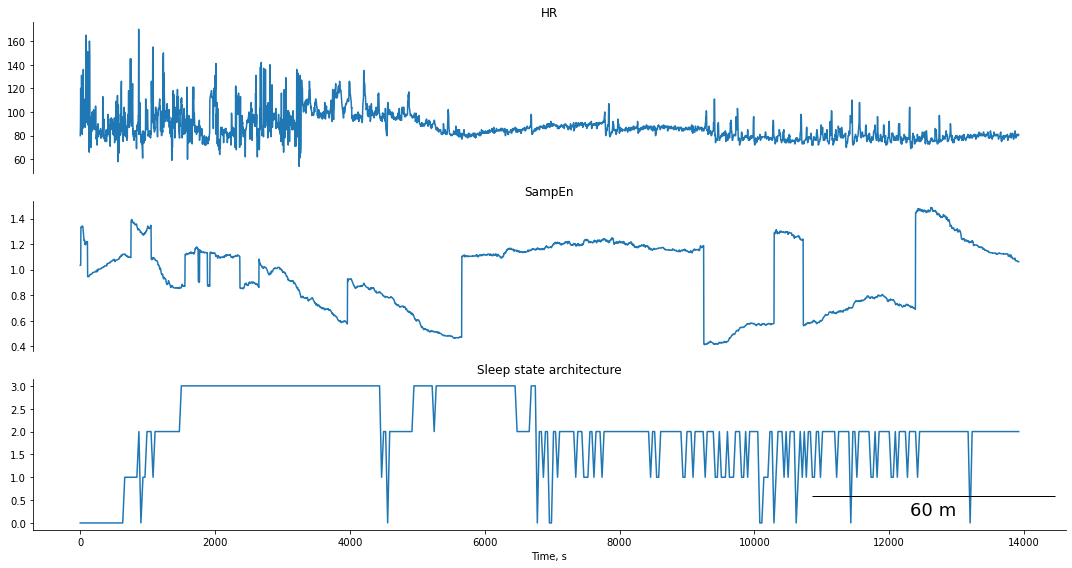

Subject 5132496:heart rate, Sample Entropy and Sleep state architecture. File saved as 5132496plot.png


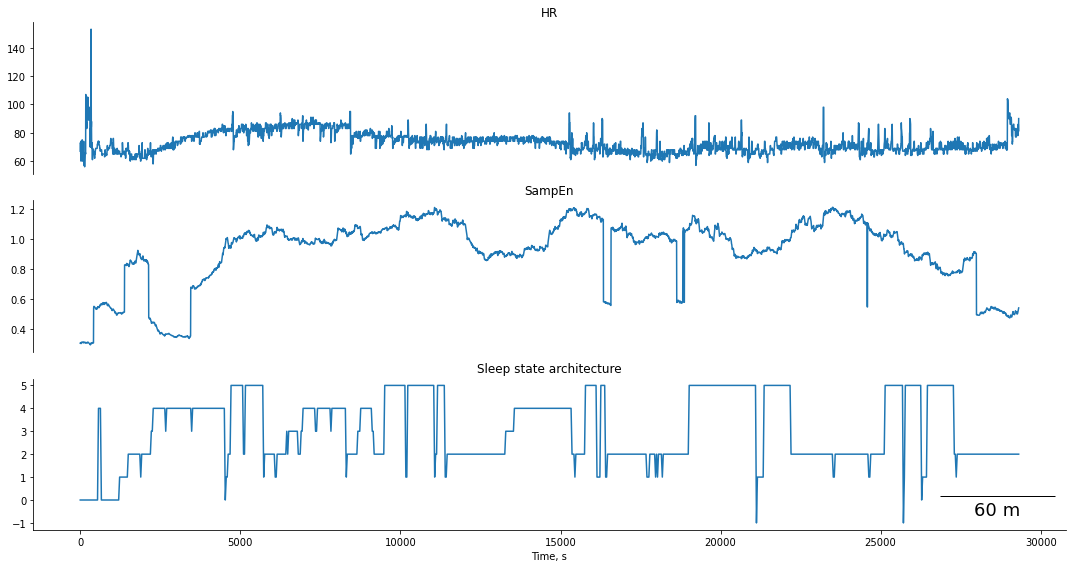

Subject 5383425:heart rate, Sample Entropy and Sleep state architecture. File saved as 5383425plot.png


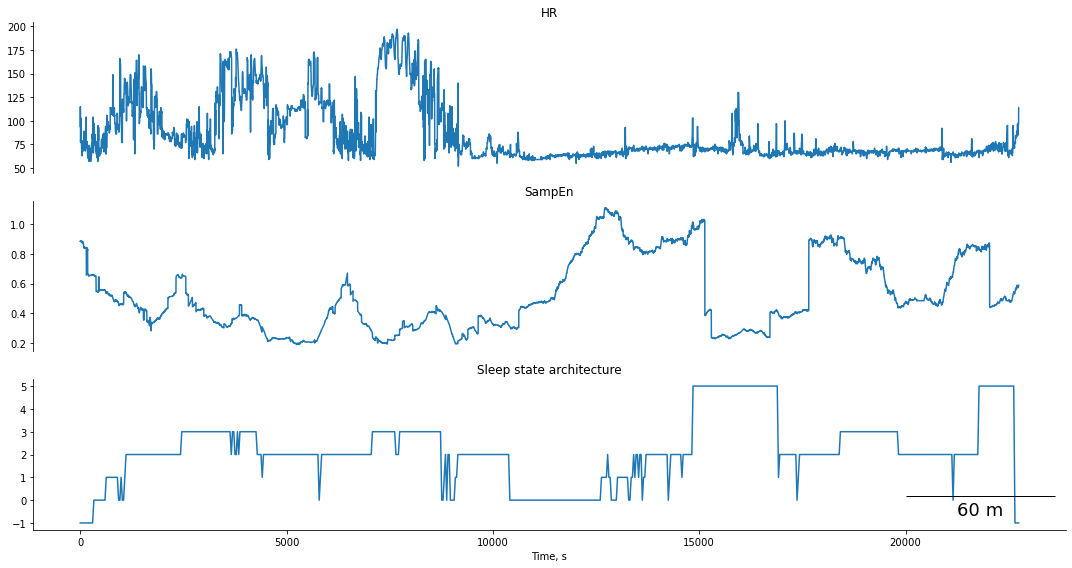

Subject 5498603:heart rate, Sample Entropy and Sleep state architecture. File saved as 5498603plot.png


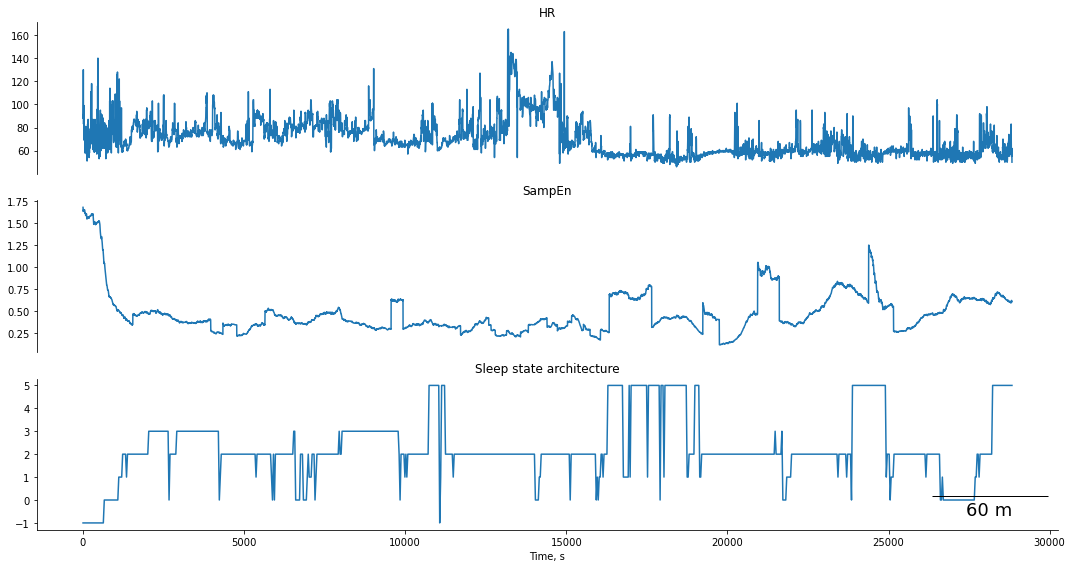

Subject 5797046:heart rate, Sample Entropy and Sleep state architecture. File saved as 5797046plot.png


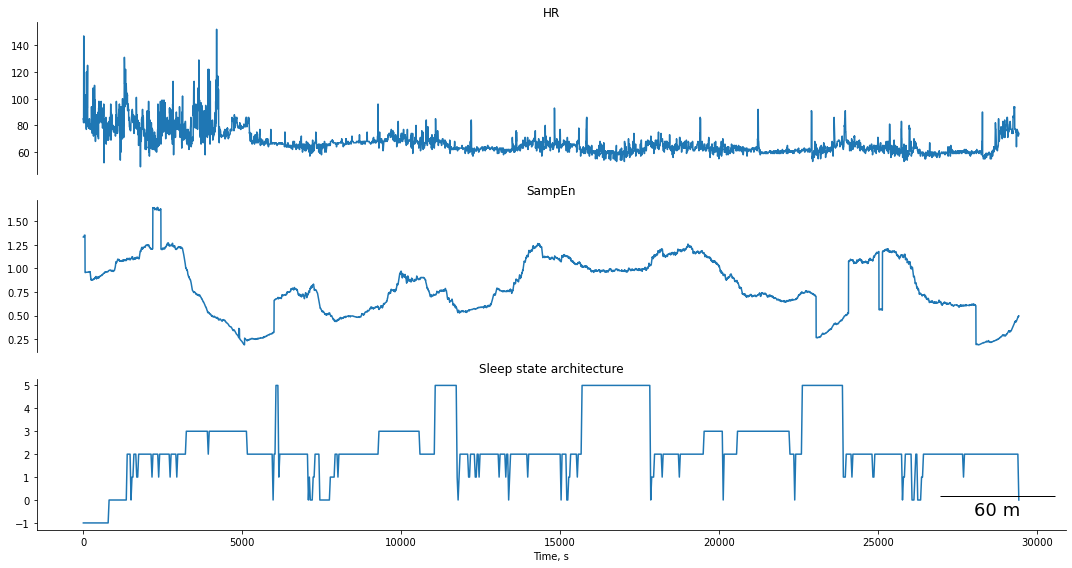

Subject 6220552:heart rate, Sample Entropy and Sleep state architecture. File saved as 6220552plot.png


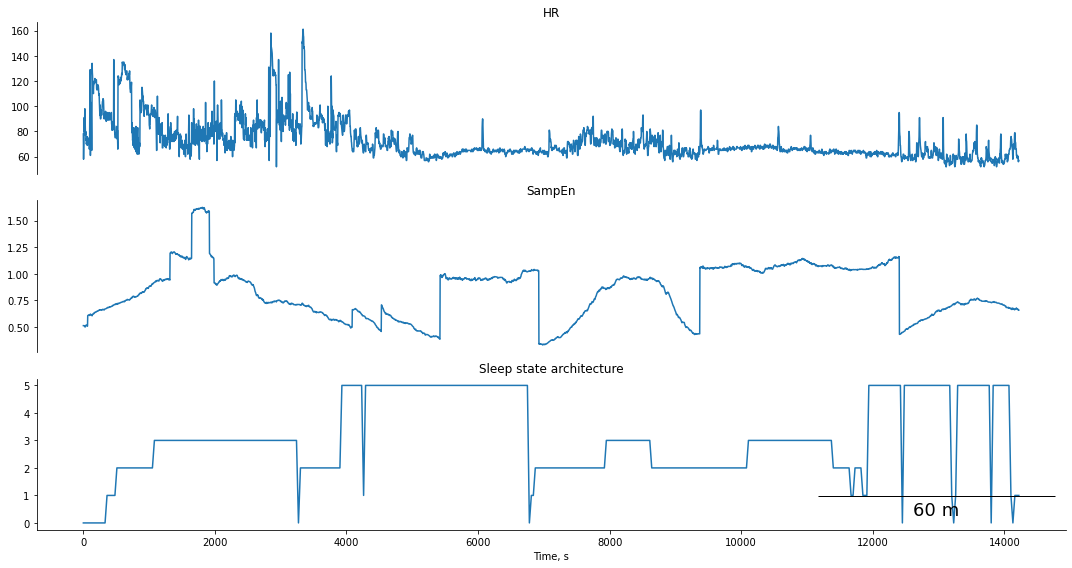

Subject 759667:heart rate, Sample Entropy and Sleep state architecture. File saved as 759667plot.png


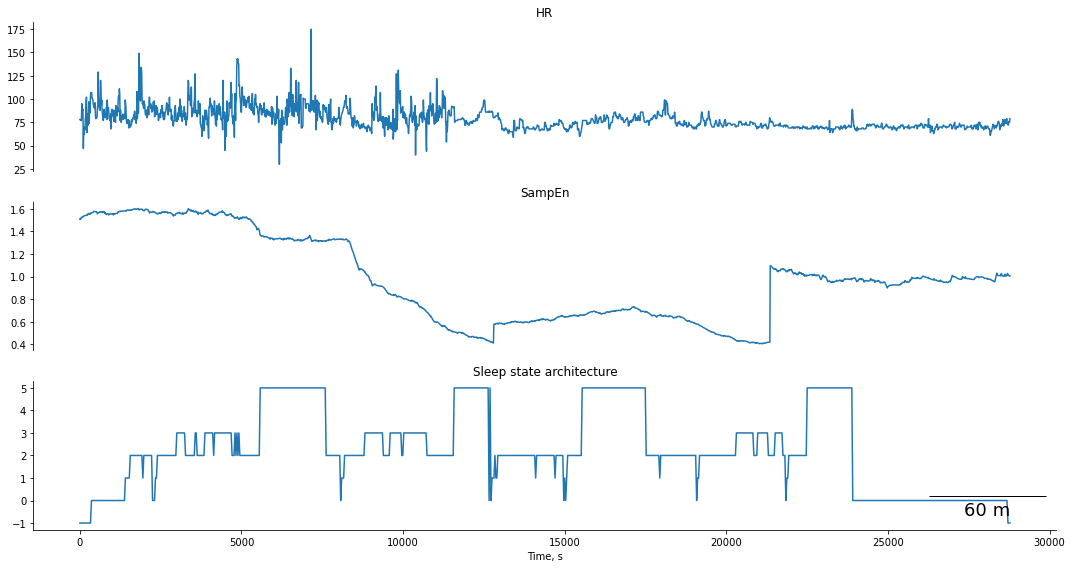

Subject 7749105:heart rate, Sample Entropy and Sleep state architecture. File saved as 7749105plot.png


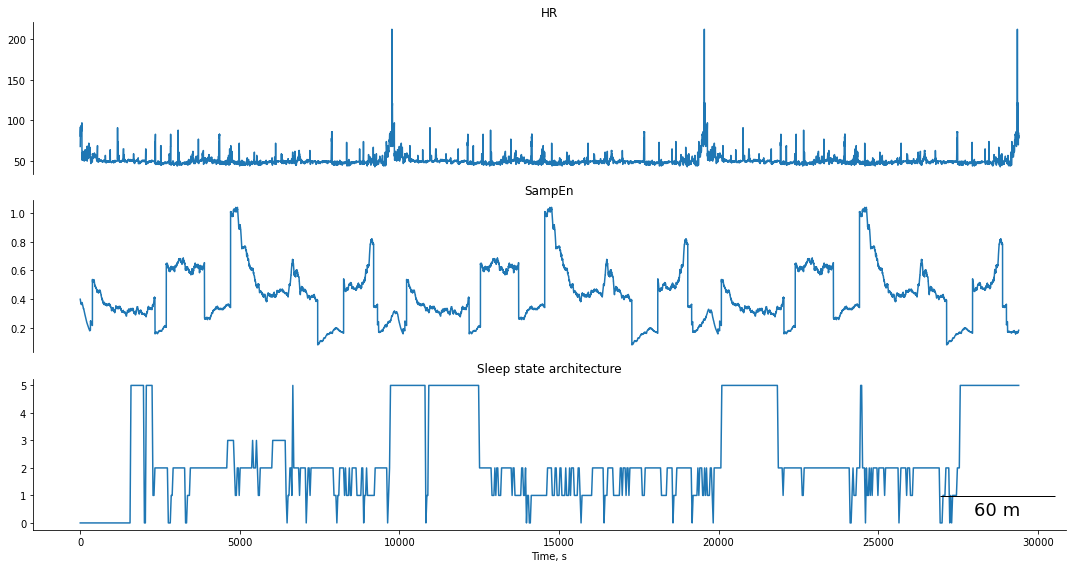

Subject 781756:heart rate, Sample Entropy and Sleep state architecture. File saved as 781756plot.png


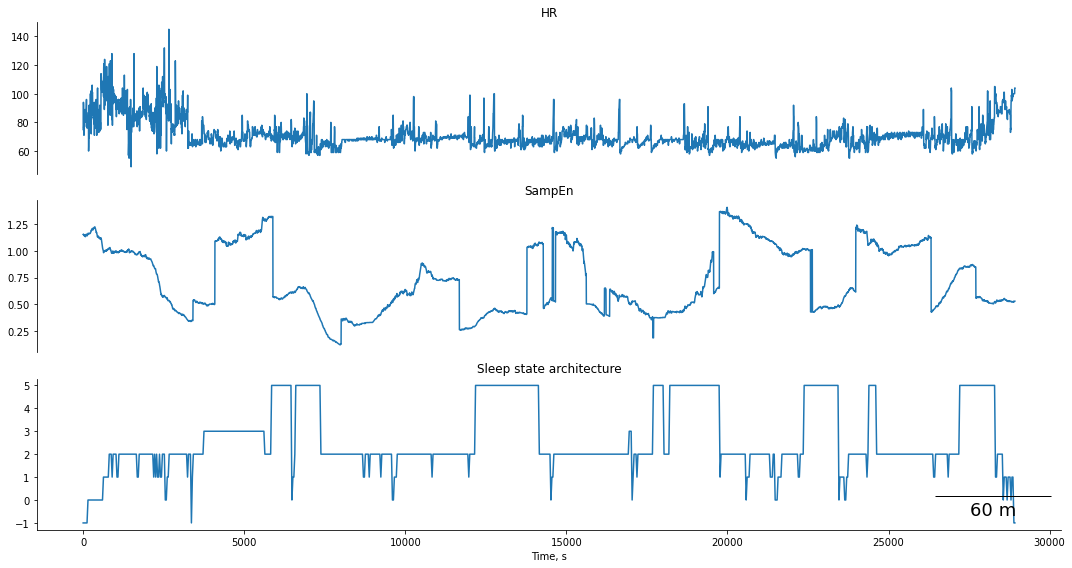

Subject 8000685:heart rate, Sample Entropy and Sleep state architecture. File saved as 8000685plot.png


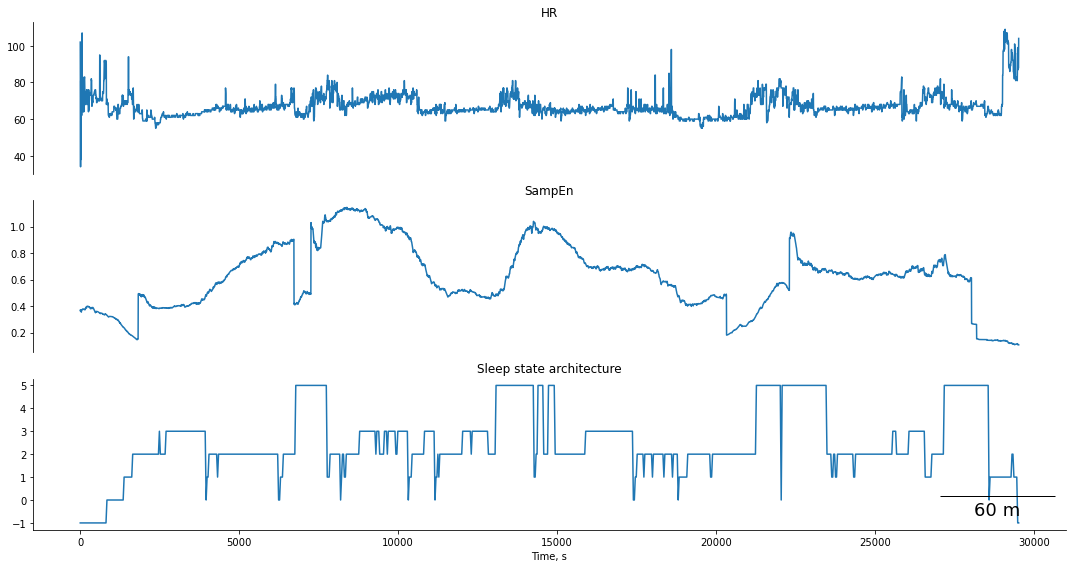

Subject 8173033:heart rate, Sample Entropy and Sleep state architecture. File saved as 8173033plot.png


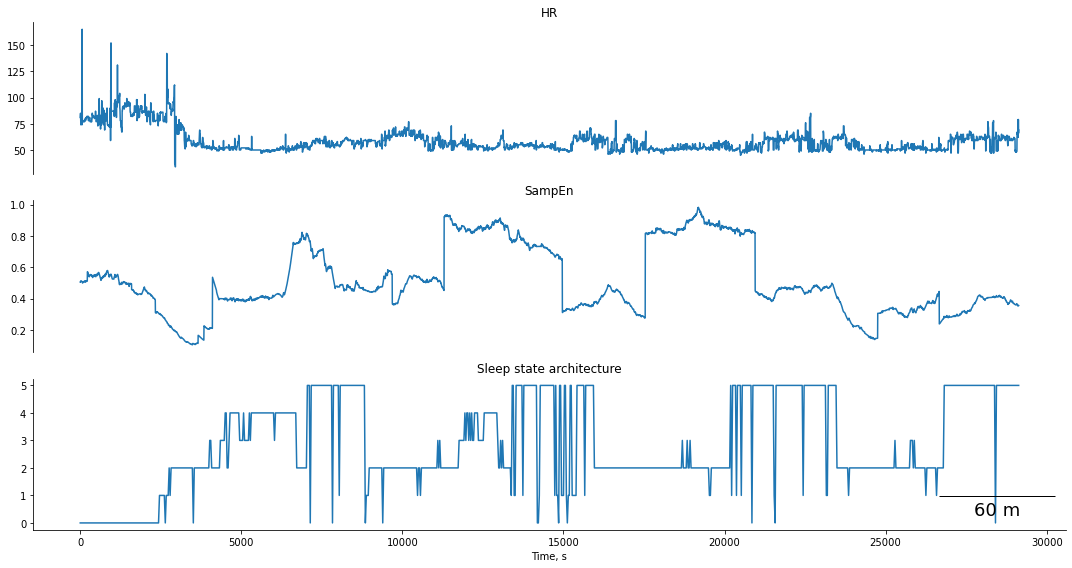

Subject 8258170:heart rate, Sample Entropy and Sleep state architecture. File saved as 8258170plot.png


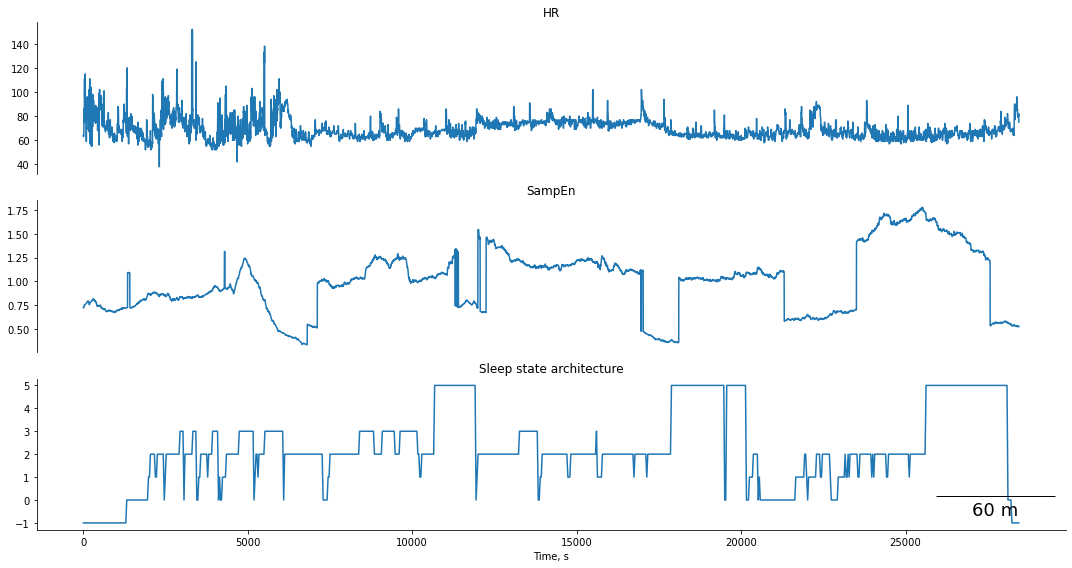

Subject 844359:heart rate, Sample Entropy and Sleep state architecture. File saved as 844359plot.png


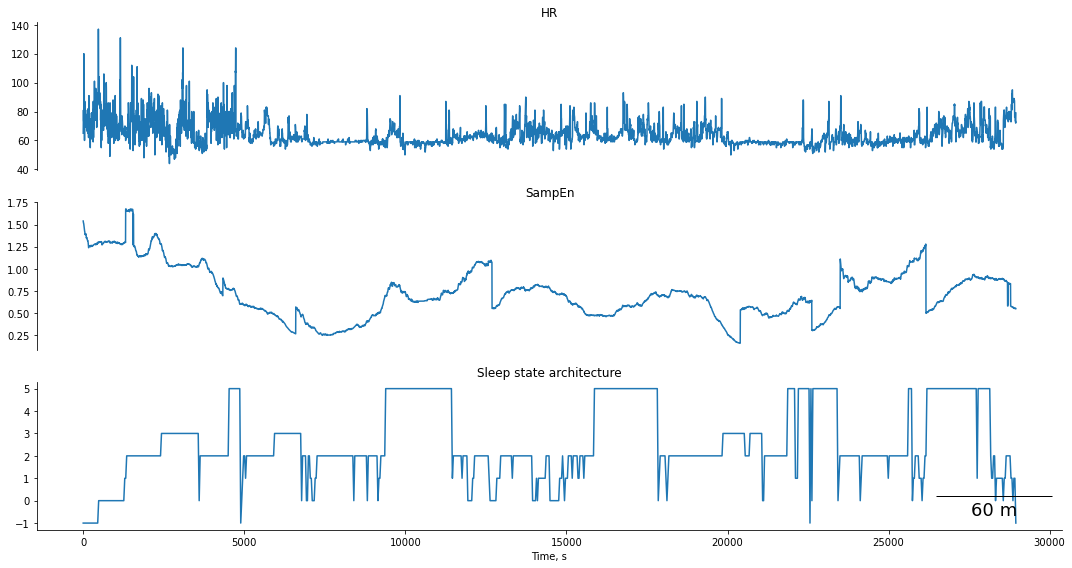

Subject 8530312:heart rate, Sample Entropy and Sleep state architecture. File saved as 8530312plot.png


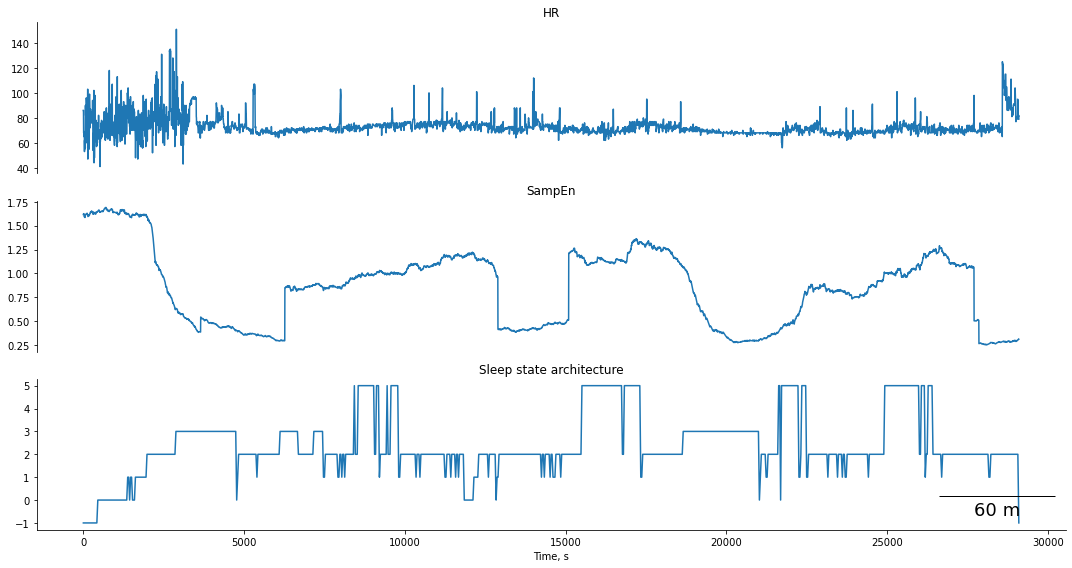

Subject 8686948:heart rate, Sample Entropy and Sleep state architecture. File saved as 8686948plot.png


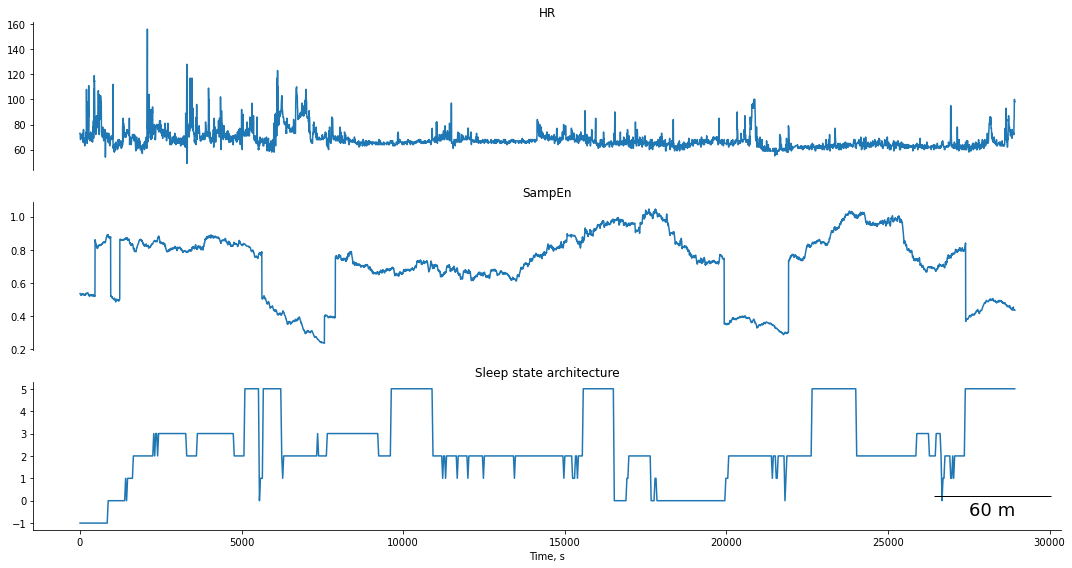

Subject 8692923:heart rate, Sample Entropy and Sleep state architecture. File saved as 8692923plot.png


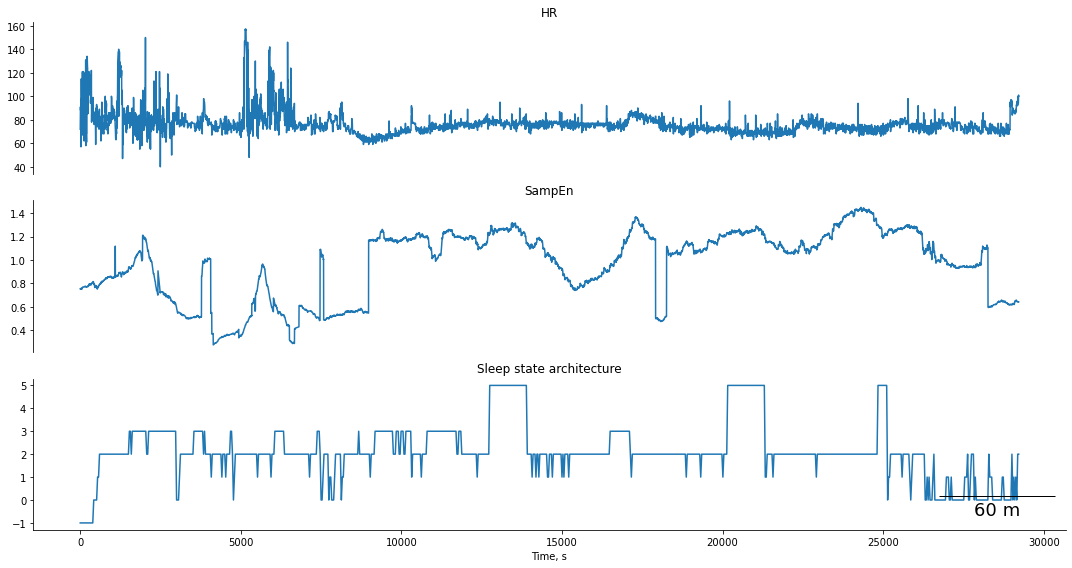

Subject 9106476:heart rate, Sample Entropy and Sleep state architecture. File saved as 9106476plot.png


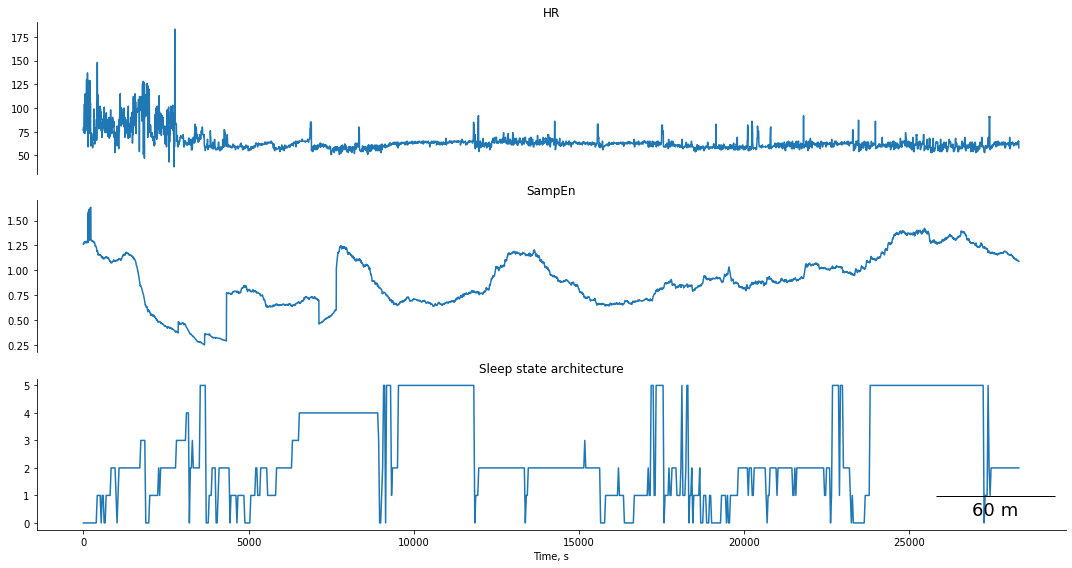

Subject 9618981:heart rate, Sample Entropy and Sleep state architecture. File saved as 9618981plot.png


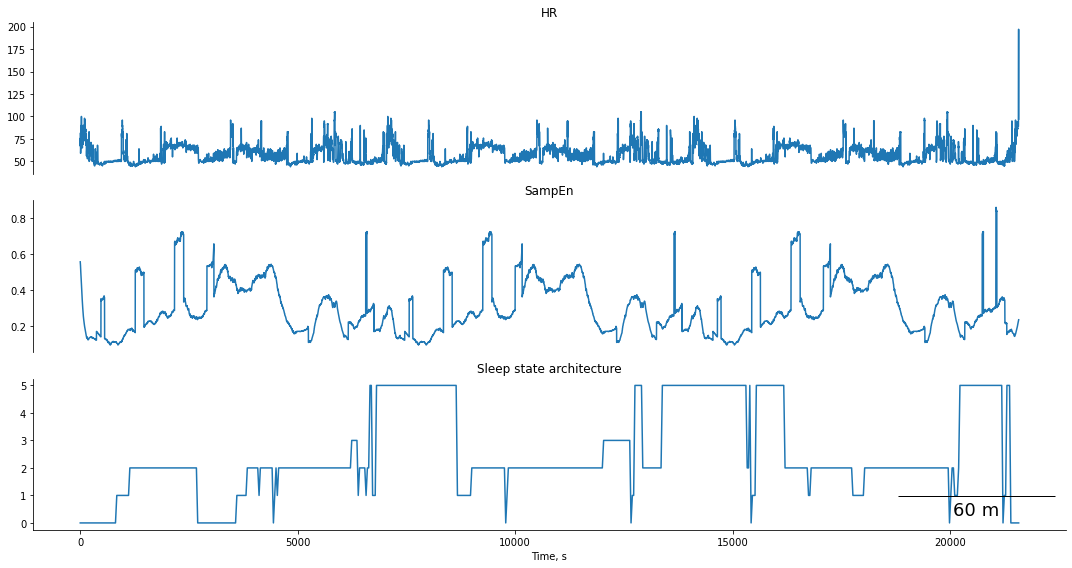

Subject 9961348:heart rate, Sample Entropy and Sleep state architecture. File saved as 9961348plot.png
Computation and visualization completed. Plots saved


In [305]:
# Create a function-wrapper that only return the index value
sampen =  lambda x: nk.entropy_sample(x)[0]


# Compute RMSSD (ms)

def compute_rmssd(bpm_file):
    rri=60000/bpm_file
    diff_rri = np.diff(rri)
    rmssd = np.sqrt(np.nanmean(diff_rri ** 2))
    return rmssd


i=0

Uber_SampEn_sleep=[]
Uber_SampEn=[]
HRV_comp_sleep_statistics_labels=['SubjectID','sleep_duration, h', 'duration_deep_sleep, min','mean SampEn','CV_sampEn','mean RMSSD','CV RMSSD']

while i<=len(bpm_files)-1:   

    # Import raw HR file in bpm
    bpm_raw=pd.read_csv(bpm_files[i])
    
    # read sleep state file; ensure the actual time axis is used for plotting, not the raw index
    sleep_label_data = pd.read_csv(sleep_label_files[i],sep=" ",header=None, parse_dates=[0],index_col=0, squeeze=True,
                 names=["Time, s", "Sleep label"])
    
    #get the subject ID from the filename; adjust this as per naming convention in a dataset
    ID=format(bpm_files[i].stem)
    # getting numbers from string
    temp = re.findall(r'\d+', ID)
    SubjectID = list(map(int, temp))[0]

    # Use the sampen function wrapper in a rolling window; adjust the window as needed
    rolling_sampen = pd.Series(bpm_raw.iloc[:,1].values).rolling(500, min_periods = 300, center=True).apply(sampen)
    rmssd=pd.Series(bpm_raw.iloc[:,1].values).rolling(500, min_periods = 300, center=True).apply(compute_rmssd)
    Uber_SampEn_rmssd_temp=[SubjectID,rolling_sampen,rmssd]
    Uber_SampEn.append(Uber_SampEn_rmssd_temp) #save raw SampEn & RMSSD values for future use
    
    # compute sleep label stats
    #get duration of sleep label file in hours from last value in "Time, s" column (here read as index) 
    sleep_duration=sleep_label_data.index[-1]/3600
    
    #select only N3 deep sleep (3rd stage, deepest sleep)
    N3_nrem=sleep_label_data.loc[sleep_label_data == 3]
    #Get duration of N3 nrem in minutes by determining the number of rows with this condition;
    #each label is assigned every 30 seconds 
    duration_deep_sleep=len(sleep_label_data[sleep_label_data == 3.0])*30/60
    
    #concatenate SubjectID,sleep duration and N3 NREM duration plus SampEn; 
    HRV_comp_sleep_statistics=[SubjectID,sleep_duration, duration_deep_sleep,np.mean(rolling_sampen),np.std(rolling_sampen) / np.mean(rolling_sampen),np.mean(rmssd),np.std(rmssd) / np.mean(rmssd)]
        
    # update the UBER_HRV_comp_sleep list
    Uber_SampEn_sleep.append(HRV_comp_sleep_statistics) 
    
    # compute SampEn metric of HRV and plot together with sleep architecture; save that plot
    vizualize_hrv_sleep_states(sleep_label_data,bpm_raw,rolling_sampen, SubjectID)
    
    i+=1
    
    if i>len(bpm_files):  
        break

#save it all into a dataframe
Uber_SampEn_sleep_df=pd.DataFrame(Uber_SampEn_sleep, columns=HRV_comp_sleep_statistics_labels)
Uber_SampEn_df=pd.DataFrame(Uber_SampEn,columns=['Subject ID','SampEn','RMSSD'])

print('Computation and visualization completed. Plots saved')

In [306]:
Uber_SampEn_sleep_df.to_excel("analysis/sleep_SampEn.xlsx")

In [307]:
Uber_SampEn_df.to_excel("analysis/RAW_SampEn.xlsx")

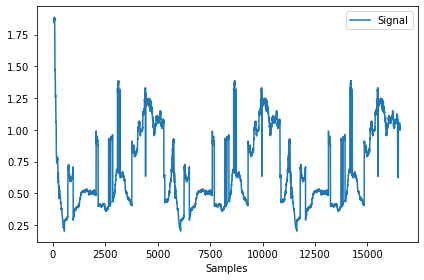

In [332]:
#We can now access any row to plot it or perform further anlayses
nk.signal_plot(Uber_SampEn_df.iloc[0,1])

### correlation matrix

In [337]:
#simple column-specific correlations

correlation=Uber_SampEn_sleep_df.iloc[:,2].corr(Uber_SampEn_sleep_df.iloc[:,3],method='spearman') 
#save the corr matrix and viz it for p<0.05
correlation

0.26658601066324045

In [341]:
x=Uber_SampEn_sleep_df.iloc[:,2] #deep sleep durations
y=Uber_SampEn_sleep_df.iloc[:,3] #mean SampEn

r, p = scipy.stats.spearmanr(x, y)  
print('r value is',r,'. The p value is',p)

r value is 0.26658601066324045 . The p value is 0.14714845196176837


In [345]:
x=Uber_SampEn_sleep_df.iloc[:,2] #deep sleep durations
y=Uber_SampEn_sleep_df.iloc[:,4] #CV SampEn

r, p = scipy.stats.spearmanr(x, y)  
print('r value is',r,'. The p value is',p)

r value is -0.1425690692427466 . The p value is 0.44421700243122


In [346]:
x=Uber_SampEn_sleep_df.iloc[:,2] #deep sleep durations
y=Uber_SampEn_sleep_df.iloc[:,5] #mean RMSSD

r, p = scipy.stats.spearmanr(x, y)  
print('r value is',r,'. The p value is',p)

r value is -0.18330308902638848 . The p value is 0.32362091516465774


In [344]:
x=Uber_SampEn_sleep_df.iloc[:,2] #deep sleep durations
y=Uber_SampEn_sleep_df.iloc[:,6] #CV RMSSD

r, p = scipy.stats.spearmanr(x, y)  
print('r value is',r,'. The p value is',p)

#note the moderate and significant correlation between deep sleep duration and CV RMSSD; let's plot it 

r value is 0.5515224955854483 . The p value is 0.0012997589378533477


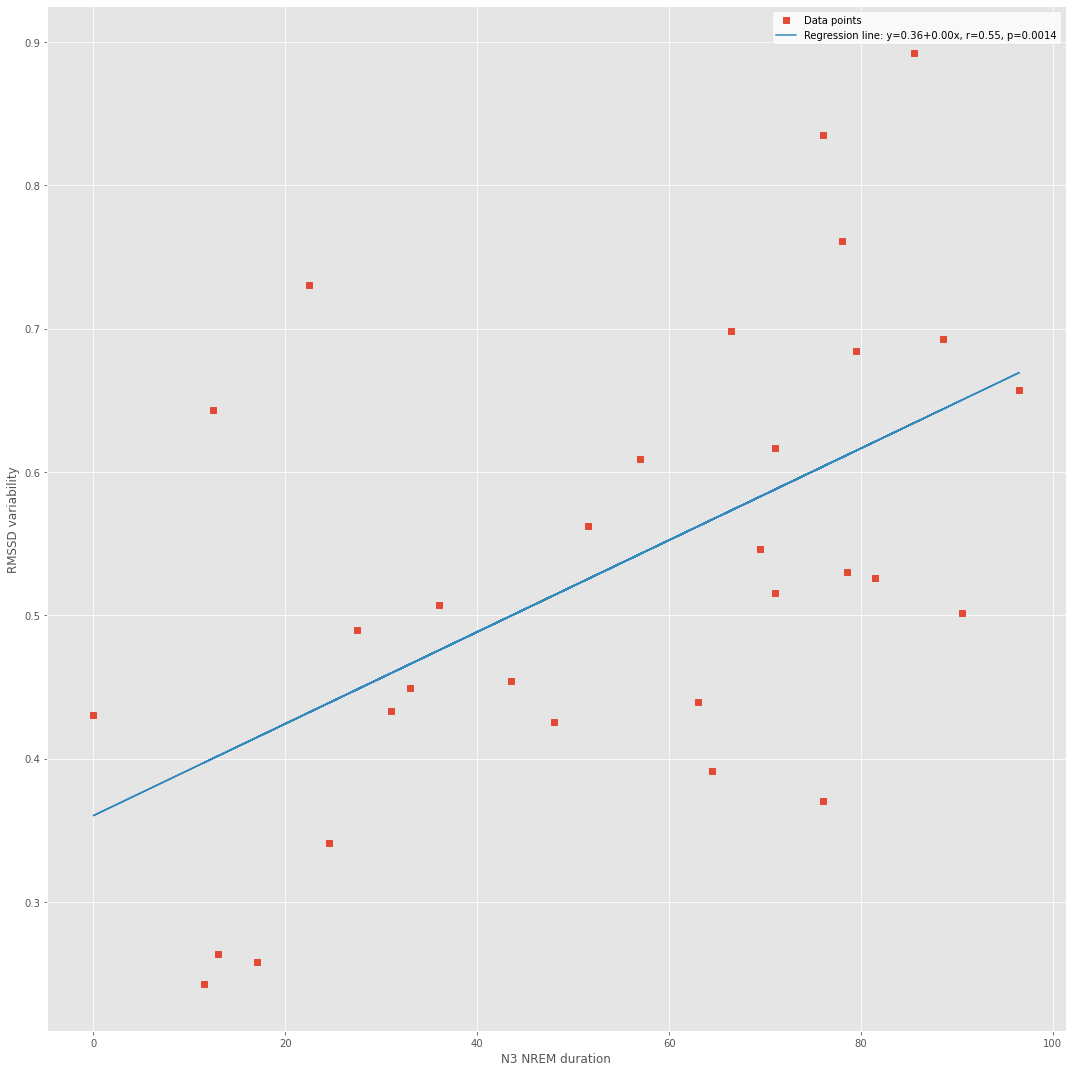

In [390]:
x=Uber_SampEn_sleep_df.iloc[:,2] #deep sleep durations
y=Uber_SampEn_sleep_df.iloc[:,6] #CV RMSSD

slope, intercept, r, p, stderr = scipy.stats.linregress(x,y) 
line = f'Regression line: y={intercept:.2f}+{slope:.2f}x, r={r:.2f}, p={p:.4f}'

fig, ax = plt.subplots(figsize=(15,15))
ax.plot(x,y, linewidth=0, marker='s', label='Data points')
ax.plot(x, intercept + slope * x, label=line)
ax.set_xlabel('N3 NREM duration')
ax.set_ylabel('RMSSD variability')
ax.legend(facecolor='white')
plt.show()

In [437]:
#now plot all correlations together as a table and a heatmap

df1 = Uber_SampEn_sleep_df.iloc[:,[1,2]]
df2 = Uber_SampEn_sleep_df.iloc[:,[3,4,5,6]]

for i in range(df1.shape[1]):    
    for j in range(df2.shape[1]):        
        corrtest = scipy.stats.spearmanr(df1[df1.columns[i]], df2[df2.columns[j]])  

        coeffmat[i,j] = corrtest[0]
        pvalmat[i,j] = corrtest[1]

# if you wish to save the r, p values
dfcoeff = pd.DataFrame(coeffmat, columns=df2.columns, index=df1.columns)
dfpvals = pd.DataFrame(pvalmat, columns=df2.columns, index=df1.columns)

print(dfcoeff,'Spearman R')
print(dfpvals,'P values')

                          mean SampEn  CV_sampEn  mean RMSSD  CV RMSSD
sleep_duration, h           -0.351755   0.393304   -0.233965 -0.405405
duration_deep_sleep, min     0.266586  -0.142569   -0.183303  0.551522 Spearman R
                          mean SampEn  CV_sampEn  mean RMSSD  CV RMSSD
sleep_duration, h            0.052315   0.028604    0.205226  0.023661
duration_deep_sleep, min     0.147148   0.444217    0.323621  0.001300 P values


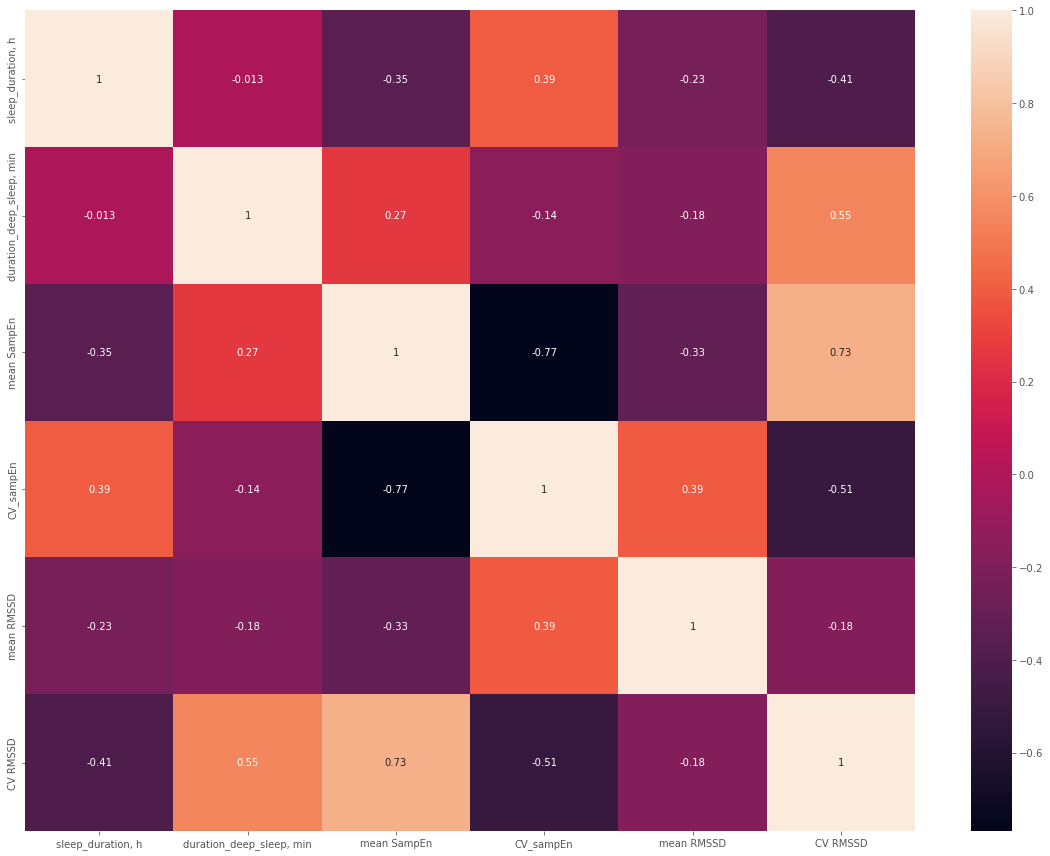

In [439]:
plt.rcParams["figure.figsize"] = (16, 12)
sns.heatmap(Uber_SampEn_sleep_df.iloc[:,[1,2,3,4,5,6]].corr(method='spearman'), annot = True)
plt.show()

now compute and viz correlations for the entire sleep state stats & HRV metrics

In [506]:
HRV_labels=np.arange(7,131).tolist()
HRV_labels

[7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130]

In [518]:
corr_final_df=pd.merge(Uber_sleep_df,Uber_HRV_df, on='SubjectID')
corr_final_df

SubjectID  sleep_duration, h  duration N3 NREM, min  \
0     1066528           7.925000                   31.0   
1     1360686           8.058333                   81.5   
2     1449548           8.033333                   36.0   
3     1455390           8.241667                    0.0   
4     1818471           8.225000                   71.0   
5     2598705           8.183333                   76.0   
6     2638030           8.066667                   63.0   
7     3509524           3.466667                   22.5   
8     3997827           8.133333                   43.5   
9     4018081           4.241667                   88.5   
10    4314139           8.075000                   48.0   
11    4426783           8.158333                   27.5   
12      46343           4.716667                   78.0   
13    5132496           3.866667                   76.0   
14    5383425           8.141667                   17.0   
15    5498603           6.316667                   78.5   
16    5797046           8.008333                   64.5   
17    6220552           8.175000                   90.5   
18     759667           3.950000                   69.5   
19    7749105           7.991667                   66.5   
20     781756           8.166667                   11.5   
21    8000685           8.033333                   33.0   
22    8173033           8.200000                   96.5   
23    8258170           8.091667                   24.5   
24     844359           7.900000                   57.0   
25    8530312           8.041667                   51.5   
26    8686948           8.083333                   85.5   
27    8692923           8.033333                   71.0   
28    9106476           8.116667                   79.5   
29    9618981           7.866667                   12.5   
30    9961348           5.991667                   13.0   

    duration N2 NREM, min  duration N1 NREM, min  duration REM, min  \
0                   149.5                   48.5              154.5   
1                   213.5                   16.5              104.0   
2                   258.5                   17.5              112.0   
3                   317.0                   28.5               90.0   
4                   267.5                   25.5              110.0   
5                   241.0                   24.5              125.5   
6                   245.5                   21.0               83.0   
7                   124.0                   11.5               24.0   
8                   259.0                   17.5              146.5   
9                    96.5                    7.0               17.5   
10                  262.0                   37.0               81.5   
11                  245.5                   30.5              151.5   
12                   85.0                   14.5               57.0   
13                  110.5                   29.5                0.0   
14                  195.5                   26.0              134.5   
15                  169.5                   21.5               49.0   
16                  265.5                   26.0               74.0   
17                  265.5                   24.5               70.5   
18                   69.0                    9.5               80.5   
19                  182.0                   12.5              109.0   
20                  230.5                   89.5              117.5   
21                  265.5                   35.0              128.5   
22                  220.5                   43.0              103.0   
23                  200.0                   24.0              148.5   
24                  208.0                   37.5               99.5   
25                  215.5                   36.0              131.5   
26                  254.0                   34.0               79.5   
27                  219.5                   19.0              103.5   
28                  283.0                   30.5        

In [522]:
#now plot all correlations together as a table and a heatmap

df1 = corr_final_df.iloc[:,[1,2,3,4,5,6]]
df2 = corr_final_df.iloc[:,HRV_labels]

coeffmat = np.zeros((df1.shape[1], df2.shape[1]))
pvalmat = np.zeros((df1.shape[1], df2.shape[1]))

for i in range(df1.shape[1]):    
    for j in range(df2.shape[1]):        
        corrtest = scipy.stats.spearmanr(df1[df1.columns[i]], df2[df2.columns[j]])  
        coeffmat[i,j] = corrtest[0]
        pvalmat[i,j] = corrtest[1]

# if you wish to save the r, p values
dfcoeff = pd.DataFrame(coeffmat, columns=df2.columns, index=df1.columns)
dfpvals = pd.DataFrame(pvalmat, columns=df2.columns, index=df1.columns)

#print(dfcoeff,'Spearman R')
#print(dfpvals,'P values')
dfpvals


HRV_MeanNN  HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  \
sleep_duration, h        0.083045  0.602875    0.456588    0.354149   
duration N3 NREM, min    0.057465  0.068652    0.111474    0.201329   
duration N2 NREM, min    0.393059  0.554588    0.287441    0.428600   
duration N1 NREM, min    0.161857  0.895464    0.875046    0.920222   
duration REM, min        0.010843  0.156322    0.192061    0.398184   
duration awake, min      0.739950  0.428742    0.471339    0.751391   

                       HRV_SDANN2  HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5  \
sleep_duration, h        0.436993    0.497140    0.358744    0.605901   
duration N3 NREM, min    0.055170    0.138755    0.059836    0.153926   
duration N2 NREM, min    0.245367    0.751318    0.192598    0.772709   
duration N1 NREM, min    0.882694    0.839512    0.850481    0.743980   
duration REM, min        0.121716    0.429474    0.111033    0.410540   
duration awake, min      0.467986    0.645881    0.537362    0.416704   

                       HRV_RMSSD  HRV_SDSD  ...  HRV_ApEn  HRV_SampEn  \
sleep_duration, h       0.031953  0.031953  ...  0.062226    0.075072   
duration N3 NREM, min   0.981103  0.981103  ...  0.372249    0.478760   
duration N2 NREM, min   0.055242  0.055242  ...  0.040165    0.058166   
duration N1 NREM, min   0.947625  0.947625  ...  0.702693    0.793453   
duration REM, min       0.624334  0.624334  ...  0.207026    0.191294   
duration awake, min     0.900599  0.900599  ...  0.958785    0.990551   

                       HRV_ShanEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn    HRV_CD  \
sleep_duration, h        0.041973  0.491630   0.837827    0.459235  0.066650   
duration N3 NREM, min    0.371660  0.063115   0.493780    0.632721  0.739950   
duration N2 NREM, min    0.607380  0.241308   0.670844    0.499170  0.410302   
duration N1 NREM, min    0.019186  0.840354   0.008475    0.202427  0.355868   
duration REM, min        0.074814  0.806031   0.227912    0.979390  0.589487   
duration awake, min      0.982821  0.865740   0.915964    0.880168  0.816863   

                        HRV_HFD   HRV_KFD   HRV_LZC  
sleep_duration, h      0.021467  0.009816  0.091206  
duration N3 NREM, min  0.005643  0.714005  0.078251  
duration N2 NREM, min  0.114234  0.244009  0.236851  
duration N1 NREM, min  0.073175  0.385246  0.333912  
duration REM, min      0.001943  0.688429  0.049311  
duration awake, min    0.901452  0.442916  0.695547  

[6 rows x 124 columns]

In [524]:
#now subset R values on p values less than 0.05
signif_R = dfcoeff[dfpvals < 0.05]
signif_R

HRV_MeanNN  HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  \
sleep_duration, h             NaN       NaN         NaN         NaN   
duration N3 NREM, min         NaN       NaN         NaN         NaN   
duration N2 NREM, min         NaN       NaN         NaN         NaN   
duration N1 NREM, min         NaN       NaN         NaN         NaN   
duration REM, min         0.45121       NaN         NaN         NaN   
duration awake, min           NaN       NaN         NaN         NaN   

                       HRV_SDANN2  HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5  \
sleep_duration, h             NaN         NaN         NaN         NaN   
duration N3 NREM, min         NaN         NaN         NaN         NaN   
duration N2 NREM, min         NaN         NaN         NaN         NaN   
duration N1 NREM, min         NaN         NaN         NaN         NaN   
duration REM, min             NaN         NaN         NaN         NaN   
duration awake, min           NaN         NaN         NaN         NaN   

                       HRV_RMSSD  HRV_SDSD  ...  HRV_ApEn  HRV_SampEn  \
sleep_duration, h      -0.386043 -0.386043  ...       NaN         NaN   
duration N3 NREM, min        NaN       NaN  ...       NaN         NaN   
duration N2 NREM, min        NaN       NaN  ...  -0.37055         NaN   
duration N1 NREM, min        NaN       NaN  ...       NaN         NaN   
duration REM, min            NaN       NaN  ...       NaN         NaN   
duration awake, min          NaN       NaN  ...       NaN         NaN   

                       HRV_ShanEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn  HRV_CD  \
sleep_duration, h       -0.367487       NaN        NaN         NaN     NaN   
duration N3 NREM, min         NaN       NaN        NaN         NaN     NaN   
duration N2 NREM, min         NaN       NaN        NaN         NaN     NaN   
duration N1 NREM, min   -0.418314       NaN   0.464502         NaN     NaN   
duration REM, min             NaN       NaN        NaN         NaN     NaN   
duration awake, min           NaN       NaN        NaN         NaN     NaN   

                        HRV_HFD   HRV_KFD   HRV_LZC  
sleep_duration, h     -0.411456 -0.456636       NaN  
duration N3 NREM, min  0.485380       NaN       NaN  
duration N2 NREM, min       NaN       NaN       NaN  
duration N1 NREM, min       NaN       NaN       NaN  
duration REM, min     -0.534677       NaN -0.356048  
duration awake, min         NaN       NaN       NaN  

[6 rows x 124 columns]

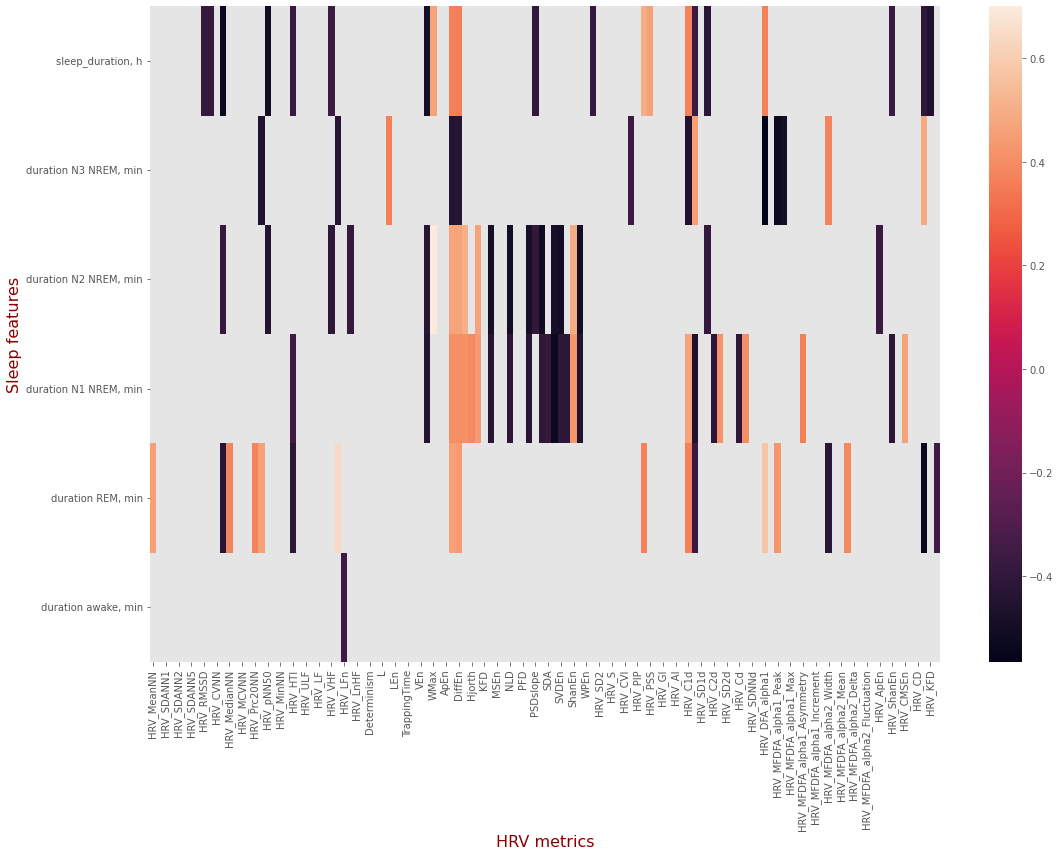

In [538]:
font = {'family': 'DejaVu Sans',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

plt.rcParams["figure.figsize"] = (16, 12)
sns.heatmap(signif_R, annot = False)
plt.xlabel('HRV metrics', fontdict=font)
plt.ylabel('Sleep features', fontdict=font)
plt.yticks(rotation = 0)
plt.show()

In [541]:
#use plotly to display only significant correlations interactively; zoom in for details

import plotly.express as px

fig = px.imshow(signif_R,labels=dict(x="HRV metrics", y="Sleep features", color="Spearman R"),title='Significant correlations (p<0.05)',
                text_auto=True, aspect="auto")
fig.show()

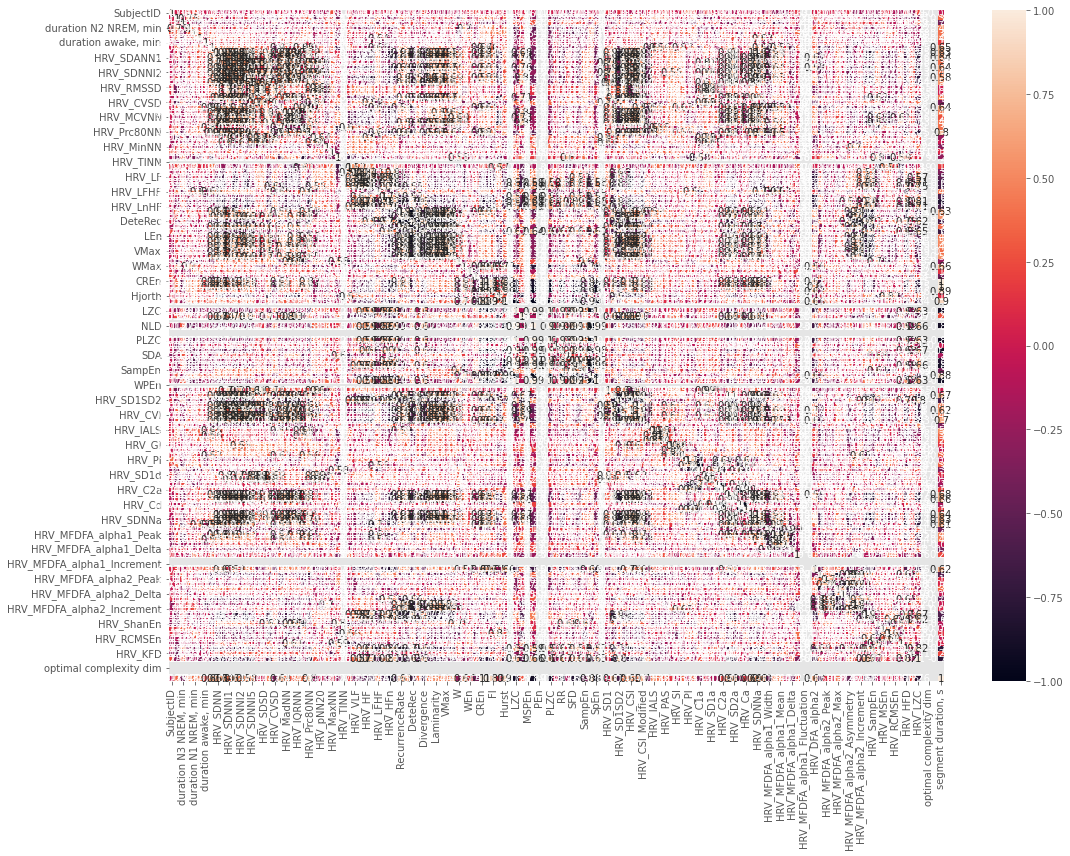

In [496]:
# simple way to show all R values in a heatmap
plt.rcParams["figure.figsize"] = (16, 12)
sns.heatmap(corr_final_df.corr(method='spearman'), annot = True)
plt.show()

In [ ]:
# use this if computing "higher HRV"

#scan the entire space of HRV metrics for which correlates to sleep state stats across the cohort

# select HRV_mean value (row) for each HRV metric (column) for all subjects: 
# note that here SubjectID is matched, so no need to join and can just feed as per below; otherwise need to join dfs on subjectID first

mean_HRV_subsetDataFrame = Uber_higher_HRV_df[Uber_higher_HRV_df[0] == 'HRV_mean']

i=1 #start with the first HRV metric which is in teh second column

for i<=len(Uber_HRV_df.columns)-1:
    correlation=Uber_sleep_df.iloc(:,2).corr(mean_HRV_subsetDataFrame.iloc(:,i),method='spearman') #verify that syntax works as per above logic    
#save the corr matrix and viz it for p<0.05


In [ ]:
# Future work based on that: predict sleep states from HRV
# Correlate sleep and HRV metrics over time (e.g., CCF?) 
# cf. https://pandas.pydata.org/docs/reference/api/pandas.Series.cov.html#pandas.Series.cov